### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import time
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import tsfresh as tsf
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import mean_squared_error #roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
init_notebook_mode(connected=True)

##### Local

In [6]:
sys.path.append(os.path.dirname(os.getcwd()))

In [7]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Metrics, _Metrics, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

### Initialization

In [8]:
cred = Cred()

In [9]:
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT']

In [10]:
quotes_or_assets = []
quotes_or_assets += [_+'USDT' for _ in bases]
# quotes_or_assets += [_+'BTC' for _ in bases if _ != 'BTC']

In [11]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_metrics = [(_, (__,)) for _ in [_+'MA' for _ in ['S', 'E', 'W', 'H']] for __ in (200, 100, 50)]
store_metrics += [('EMA', (26,)), ('EMA', (12,))]
store_signals = None

In [12]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_metrics=store_metrics)

### Update

In [13]:
print(datetime.utcnow().replace(microsecond=0))

2021-03-23 16:45:14


In [14]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

Timestamp('2021-03-23 14:00:00')

In [ ]:
klmngr.update(verbose=2)

In [19]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

Timestamp('2021-03-22 14:00:00')

### Exploration

Future values scaler correction

In [20]:
from cryptoast.model.processing import corrector

In [32]:
asset_nr = 3
asset = klmngr.assets[asset_nr]
data = klmngr[asset].close.values
scaler_to_test = StandardScaler() # MinMaxScaler((-1, 1))
scaler = StandardScaler()

print(asset)

BATUSDT


C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning:

invalid value encountered in subtract

C:\Users\guill\miniconda3\envs\cryptoast\lib\site-packages\scipy\stats

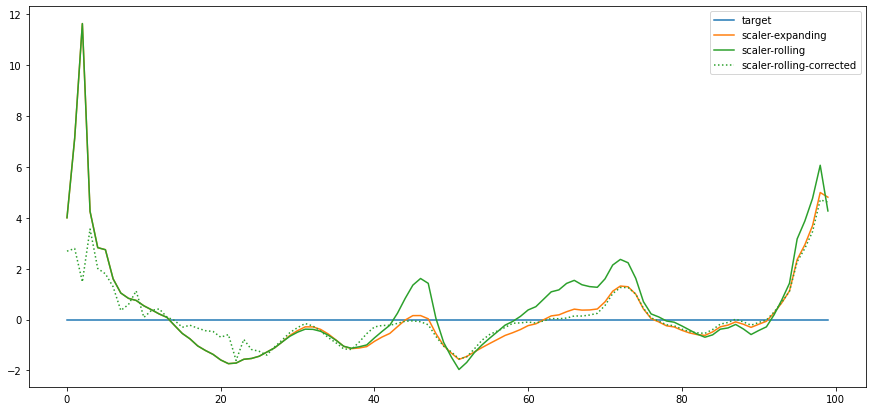

In [52]:
steps = 100
window = int(data.size/steps)
validation_window = 24*30
historical_window = 5000

means0, means1, means2, means3 = [[] for _ in range(4)]

for i in range(steps):
    
    scaler = scaler.fit(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means0.append(np.mean(data_scaled))

    scaler = scaler.fit(data[:(i+1)*window].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means1.append(np.mean(data_scaled))

    scaler = scaler.fit(data[:(i+1)*window][-historical_window:].reshape(-1, 1))
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means2.append(np.mean(data_scaled))
 
    corrected_data = corrector(data[:(i+1)*window].reshape(-1, 1), validation_window)
    scaler = scaler.fit(corrected_data)
    data_scaled = scaler.transform(data[(i+1)*window:][:validation_window].reshape(-1, 1))
    means3.append(np.mean(data_scaled))

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(means0, label='target', color='C0')
plt.plot(means1, label='scaler-expanding', color='C1')
plt.plot(means2, label='scaler-rolling', color='C2')
plt.plot(means3, label='scaler-rolling-corrected', color='C2', linestyle=':')
plt.legend()

##### Gaps

In [14]:
_ = 'BTCUSDT' #klmngr.assets[4]

In [15]:
set(pd.date_range(klmngr[_].start, klmngr[_].end, freq='H')) - set(klmngr[_].index)

{Timestamp('2017-09-06 16:00:00', freq='H'),
 Timestamp('2017-09-06 17:00:00', freq='H'),
 Timestamp('2017-09-06 18:00:00', freq='H'),
 Timestamp('2017-09-06 19:00:00', freq='H'),
 Timestamp('2017-09-06 20:00:00', freq='H'),
 Timestamp('2017-09-06 21:00:00', freq='H'),
 Timestamp('2017-09-06 22:00:00', freq='H'),
 Timestamp('2018-01-04 04:00:00', freq='H'),
 Timestamp('2018-02-08 01:00:00', freq='H'),
 Timestamp('2018-02-08 02:00:00', freq='H'),
 Timestamp('2018-02-08 03:00:00', freq='H'),
 Timestamp('2018-02-08 04:00:00', freq='H'),
 Timestamp('2018-02-08 05:00:00', freq='H'),
 Timestamp('2018-02-08 06:00:00', freq='H'),
 Timestamp('2018-02-08 07:00:00', freq='H'),
 Timestamp('2018-02-08 08:00:00', freq='H'),
 Timestamp('2018-02-08 09:00:00', freq='H'),
 Timestamp('2018-02-08 10:00:00', freq='H'),
 Timestamp('2018-02-08 11:00:00', freq='H'),
 Timestamp('2018-02-08 12:00:00', freq='H'),
 Timestamp('2018-02-08 13:00:00', freq='H'),
 Timestamp('2018-02-08 14:00:00', freq='H'),
 Timestamp

##### Total size

In [16]:
np.sum([_.shape[0] for _ in klmngr.listedvalues()])

313947

In [26]:
[(_.name, _.shape[0]) for _ in klmngr.listedvalues()]

[('BTCUSDT', 28030),
 ('ETHUSDT', 28030),
 ('NEOUSDT', 25758),
 ('LTCUSDT', 25206),
 ('ADAUSDT', 22238),
 ('XRPUSDT', 21826),
 ('EOSUSDT', 21253),
 ('IOTAUSDT', 21177),
 ('XLMUSDT', 21177),
 ('TRXUSDT', 20911),
 ('LINKUSDT', 15684),
 ('BATUSDT', 14556),
 ('XMRUSDT', 14304),
 ('DASHUSDT', 13992),
 ('XTZUSDT', 9683),
 ('BCHUSDT', 8128),
 ('YFIUSDT', 1994)]

### Artificial USDT

### Ad-hoc analysis

Btc

<AxesSubplot:>

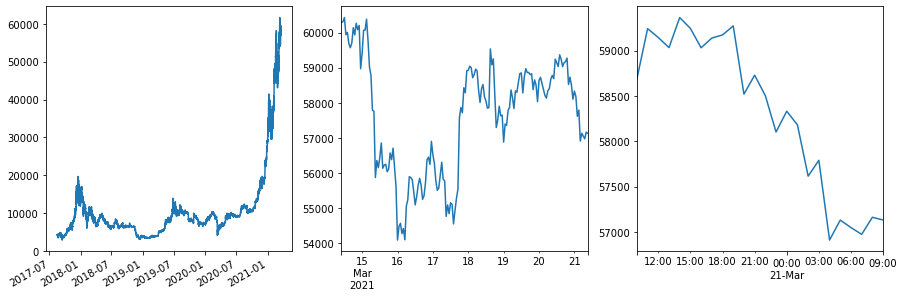

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
kline = klmngr['BTCUSDT']
kline.close.plot(ax=ax[0])
kline.close[-24*7:].plot(ax=ax[1])
kline.close[-24:].plot(ax=ax[2])

Bmp

In [173]:
bmp = klmngr.get_bmp(components=True)

C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\numpy\core\_asarray.py:83: UserWarning:




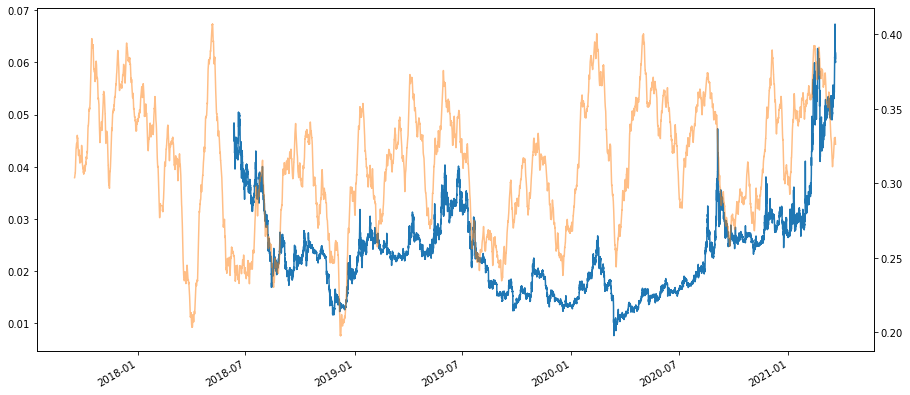

In [176]:
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()
klmngr['TRXUSDT'].close.plot(ax=ax)
bmp.mean(1).rolling(24*30).mean().plot(ax=ax2, color='C1', alpha=.5)
plt.hlines(0.5, kline.index.min(), kline.index.max(), color='C1', alpha=.5)

All asset signals

In [18]:
pd.DataFrame(klmngr.signals(index=slice(-24, None))).T.mean(1).sort_values(ascending=False)

BTTUSDT      0.583333
XRPUSDT      0.572917
VETUSDT      0.562500
OCEANUSDT    0.552083
IOTAUSDT     0.447917
TRXUSDT      0.447917
UNIUSDT      0.406250
LSKUSDT      0.364583
ANTUSDT      0.322917
BATUSDT      0.312500
KMDUSDT      0.312500
XMRUSDT      0.291667
XLMUSDT      0.291667
YFIUSDT      0.270833
SNXUSDT      0.270833
REPUSDT      0.260417
ONTUSDT      0.250000
MKRUSDT      0.229167
ZRXUSDT      0.229167
CHZUSDT      0.218750
BTCUSDT      0.208333
OMGUSDT      0.197917
QTUMUSDT     0.197917
WAVESUSDT    0.197917
NEOUSDT      0.187500
DOTUSDT      0.187500
DGBUSDT      0.177083
RENUSDT      0.177083
AAVEUSDT     0.177083
ADAUSDT      0.156250
ATOMUSDT     0.156250
KNCUSDT      0.156250
ALGOUSDT     0.145833
XTZUSDT      0.145833
XEMUSDT      0.145833
ETHUSDT      0.145833
UMAUSDT      0.145833
LTCUSDT      0.135417
AVAXUSDT     0.125000
LINKUSDT     0.125000
BCHUSDT      0.114583
BANDUSDT     0.114583
COMPUSDT     0.114583
EOSUSDT      0.062500
DASHUSDT     0.020833
dtype: flo

Single asset signals

In [17]:
portfolio

['ADA', 'NEO', 'XRP', 'XLM', 'DOT', 'BAT']

In [18]:
sell = ['BAT', 'ADA']

In [19]:
buy = ['NEO', 'XTZ', 'EOS']

In [20]:
hard_predict = ['XTZ', 'IOTA', 'EOS']

In [13]:
asset = 'OCEAN'
kline = klmngr[asset+'USDT']
print(kline.asset)

OCEANUSDT


In [38]:
fig = go.Figure()

In [ ]:
kline.daily.plot(365, fig=fig)

In [40]:
fig.write_html('0.html')

In [ ]:
kline.plot(24*7, signals=kline.signals.columns.tolist(), fig=fig)

In [83]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)

def set_nested_value(dic, keys, value):
    for key in keys[:-1]:
        dic = dic.setdefault(key, {})
    dic[keys[-1]] = value

grid = {}
lower_best, upper_best = .8, .1
for year in kline.index.year.unique():
    for month in kline.loc[kline.index.year==year].index.month.unique():
        print(year, month)
        set_nested_value(grid, [year, month], (lower_best, upper_best))
        kline_sel = kline.loc[(kline.index.year<=year) & (kline.index.month<=month)]
        pct_change_avg = -np.inf
        for upper in np.linspace(1, 2, 5):
            for lower in np.unique(np.maximum(upper-np.array([0.4, 0.2, 0.1, 0]), 0)):
                __sigs = kline_sel.signals.iloc[:, :4].mean(axis=1).shift(1)
                _sigs = (__sigs.rolling(24*1).mean() /
                         __sigs.rolling(24*30*1).mean()).fillna(2).values[:-1]
                sigs = np.where(_sigs>=upper, 1, np.where(_sigs<lower, -1, 0))
                periodic = pd.DataFrame.from_dict(btst.stepx(orders=sigs*999)[0], orient='index')
                pct_changes = periodic.value.pct_change()
                #pct_changes[pct_changes<0] = pct_changes[pct_changes<0] *1.1
                pct_change_avg_new = pct_changes.mean()
                if pct_change_avg_new > pct_change_avg:
                    pct_change_avg = pct_change_avg_new
                    lower_best, upper_best = lower, upper

2018 5


C:\Users\guill\OneDrive\Documents\Code\crypto-invest\cryptoast\base\kline.py:424: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\guill\OneDrive\Documents\Code\crypto-invest\cryptoast\base\kline.py:424: RuntimeWarning:

invalid value encountered in true_divide



2018 6
2018 7
2018 8
2018 9
2018 10
2018 11
2018 12
2019 1
2019 2
2019 3
2019 4
2019 5
2019 6
2019 7
2019 8
2019 9
2019 10
2019 11
2019 12
2020 1
2020 2
2020 3
2020 4
2020 5
2020 6
2020 7
2020 8
2020 9
2020 10
2020 11
2020 12
2021 1
2021 2


In [84]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
__sigs = kline.signals.iloc[:, :4].mean(axis=1).shift(1).iloc[:-1]
_sigs = __sigs.rolling(24).mean().fillna(1)
sigs = np.where(_sigs>=.8, 1, np.where(_sigs<0.4, -1, 0))

lower_upper_best = np.array([grid[r.year][r.month] for r in _sigs.index])
lowers, uppers = lower_upper_best[:, 0], lower_upper_best[:, 1]
__sigs2 = kline.signals.iloc[:, :4].mean(axis=1).shift(1)
_sigs2 = (__sigs2.rolling(24*1).mean() / __sigs2.rolling(24*30*1).mean()).fillna(3).values[:-1]
sigs2 = np.where(_sigs2>=uppers, 1, np.where(_sigs2<lowers, -1, 0))

sigs[:(_sigs2==3).sum()] = 1

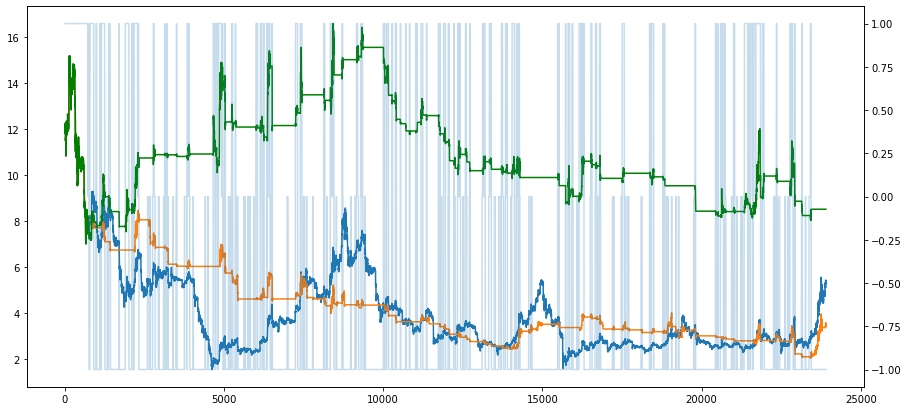

In [85]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(kline.close.values)
ax.plot(pd.DataFrame.from_dict(btst.stepx(orders=999*sigs)[0], orient='index').value.values)
ax.plot(pd.DataFrame.from_dict(btst.stepx(orders=999*sigs2)[0], orient='index').value.values, color='green')
#ax.plot(pd.DataFrame.from_dict(btst.stepx(orders=999*sigs3)[0], orient='index').value.values, color='deeppink')
ax2 = ax.twinx()
ax2.plot(sigs2, alpha=.25)

In [ ]:
plt.plot(sigs[-24*7:])

In [ ]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Baseline

Multi asset

In [13]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

In [ ]:
values = []
inf = 1e100
last_bought_asset = 'BTCUSDT'
start = klmngr[last_bought_asset].start
end = max([klmngr[_].end for _ in klmngr])
index_full = pd.date_range(start, end, freq='H')
klmngr_full = klmngr.reindex(index_full)
btst = Backtest(klmngr_full[last_bought_asset],
                start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)

for dttm in pd.date_range(start, end-pd.Timedelta(hours=1), freq='H'):
    values.append(btst.history[-1][-1])
    if dttm.hour != 8: # or dttm.dayofweek != 0:
        btst.step(0)
        continue
    index_signals = pd.date_range(start, dttm, freq='H')
    # signal_means = pd.DataFrame(klmngr.reindex(index_signals).signals(index=slice(-3, None))).T.mean(1) # None OK or not?!
    group = lambda df: np.mean(df, axis=1)
    # signal_means = pd.DataFrame(klmngr.reindex(index_signals).signals(index=slice(-24, None), func=group)).apply(lambda df: np.average(df, weights=get_weights(df.shape[0], 'exp', 2, 30)))
    signal_means = pd.DataFrame(klmngr.reindex(index_signals).signals(index=slice(-3, None), func=group)).apply(lambda df: np.average(df))
    if signal_means.isnull().all():
        btst.step(0)
        continue
    top_asset, top_value = signal_means.dropna().sort_values(ascending=False).reset_index().values[0]
    if top_value <= .5:
        btst.step(-inf)
        continue
    if (top_asset == last_bought_asset) or (top_value <= .85): # 7
        btst.step(0)
        continue
    index_current = pd.date_range(dttm, end, freq='H')
    kline = klmngr_full[top_asset].loc[index_current]
    init_cash = btst._periodic[dttm]['value']
    print(dttm, top_asset, init_cash)
    btst = Backtest(kline, start_index=0, init_assets=0, init_cash=init_cash, commission=0.001, slippage_pct=0.1, slippage_steps=0)
    btst.step(inf)
    last_bought_asset = top_asset

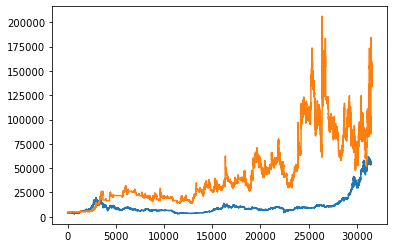

In [279]:
# Decision every 24h - inf - sell
plt.plot(klmngr['BTCUSDT'].close.values)
plt.plot(values)

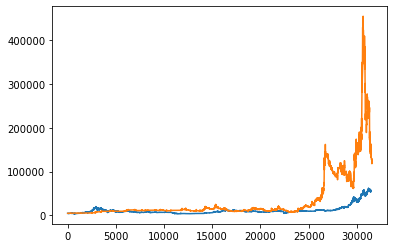

In [289]:
# Decision every 24h - inf - sell
plt.plot(klmngr['BTCUSDT'].close.values)
plt.plot(values)

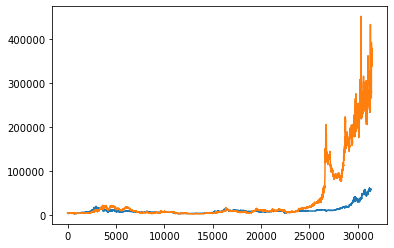

In [107]:
# Decision every 24h - inf - sell
plt.plot(klmngr['BTCUSDT'].close.values)
plt.plot(values)

Single asset

In [23]:
from cryptoast.model.agents import SingleAssetEnv

In [ ]:
klmngr.assets

In [61]:
kline = klmngr['BATUSDT'] # klmngr[klmngr.assets[1]]
print(kline.asset)

BATUSDT


In [62]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.iloc[:, :4].mean(axis=1).shift(1).values[:-1]
#_sigs = pd.Series(_sigs).rolling(24).mean().fillna(1)
_sigs = pd.Series(_sigs).rolling(3).mean().fillna(1)
sigs = np.where(_sigs>=.8, 1, np.where(_sigs<0.4, -1, 0)) # sigs = np.where(sigs>=0.15, 1, np.where(sigs<=-0.05, -1, 0))

In [63]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

In [64]:
_sigs = kline.daily.signals.iloc[:, :4].mean(1).shift(1).asfreq('H', 'ffill').values[:-1]
_sigs = pd.Series(_sigs).rolling(3).mean().fillna(1)
sigs = np.where(_sigs>=.5, 1, np.where(_sigs<0.4, -1, 0)) # sigs = np.where(sigs>=0.15, 1, np.where(sigs<=-0.05, -1, 0))
sigs = sigs[:kline.shape[0]-1]

In [84]:
btst2 = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst2.run(999*sigs, verbose=0)

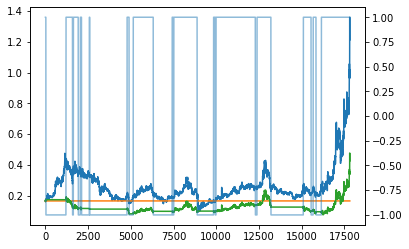

In [66]:
# 0.8, 0.4 # Most stable accross bullish / bearish
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax.plot(btst2.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

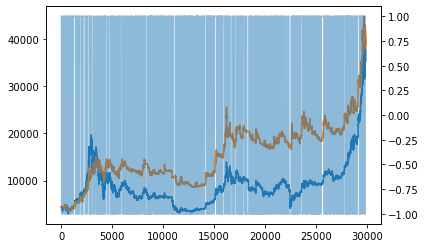

In [97]:
# 0.4, 0.5
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

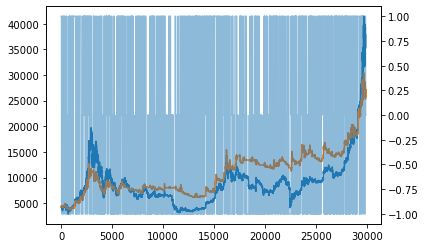

In [156]:
# 0.6, 0.4
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

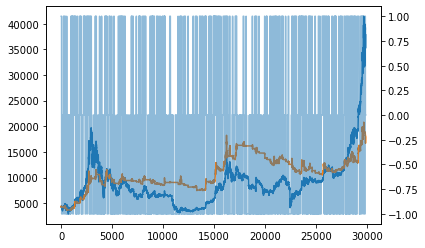

In [152]:
# 0.8, 0.4 # Most stable accross bullish / bearish
fig, ax = plt.subplots()
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Model test 2: RF

##### Discrete action, Single Process

In [123]:
train_assets = list(set(klmngr.assets)-set(['BTCUSDT']))

Testing ground

In [129]:
from cryptoast.model.agents import SingleAssetEnv

In [130]:
asset = np.random.choice(klmngr.assets) # 'BTCUSDT'
btst = Backtest(kline=klmngr[asset])
env = SingleAssetEnv(klmngr, assets=train_assets, backtest=btst, window=24, )

6


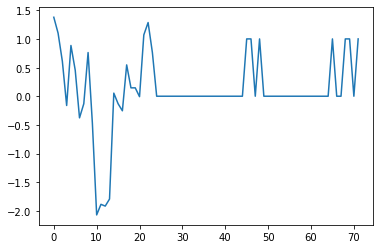

In [136]:
obs = env.step(np.random.choice([0, 1, 2]))[0]
print(env.current_step)
plt.plot(obs)

In [137]:
check_env(env, warn=True)

1.0016478614188395


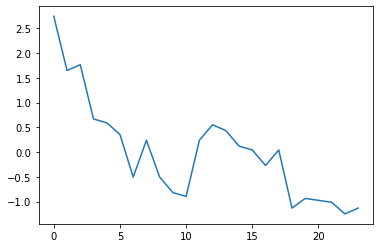

In [138]:
obs, reward, _, __ = env.step(2)
plt.plot(obs[:24])
print(reward)

DQN

In [139]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP
from stable_baselines.common.callbacks import EvalCallback

In [ ]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [160]:
window = 24*2 #7
# btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0.01, slippage_steps=0, memory=window)
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0, slippage_steps=0, memory=window)
env_kwargs = dict(klmngr=klmngr,
                  assets=list(set(klmngr.assets)-set(['BTCUSDT'])),
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=24*30*2)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
eval_callback = EvalCallback(env, best_model_save_path='./models/h5/',
                             log_path='./models/logs/', eval_freq=500,
                             deterministic=True, render=False)

In [161]:
total_timesteps = 500*1000
model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, tensorboard_log='C:/Users/guill/Documents/Code/crypto-invest/models/logs', verbose=1).learn(total_timesteps)
# model = PPO(policy='MlpPolicy', env=env, verbose=1).learn(total_timesteps)
# model = A2C(policy='MlpPolicy', env=env, verbose=1).learn(total_timesteps)

model.learn(total_timesteps) # callback=eval_callback

--------------------------------------
| % time spent exploring  | 17       |
| episodes                | 100      |
| mean 100 episode reward | -430     |
| steps                   | 84135    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | -75.7    |
| steps                   | 165809   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | -62.4    |
| steps                   | 242620   |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | -74.4    |
| steps                   | 325347   |
--------------------------------------
--------------------------------------
| % time spent exploring 

In [162]:
env_kwargs.update(dict(assets=['BTCUSDT'],
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
# env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
model.load(load_path='./models/h5/best_model.zip', env=env)

In [163]:
obs = env.reset()
n_steps = 8000
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
    action, _ = model.predict(obs, deterministic=False)
    # action = np.random.choice([0, 1, 2], p=model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_list.append(reward)
    action_list.append(action)
    values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
#     if step%1000==0:
#         print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

In [ ]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

300K


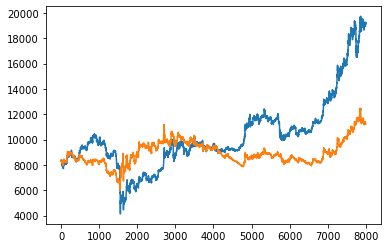

In [144]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


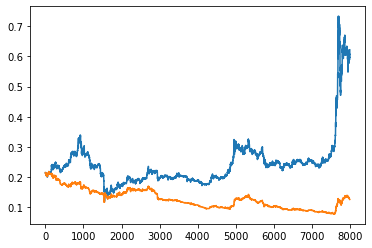

In [281]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['XRPUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


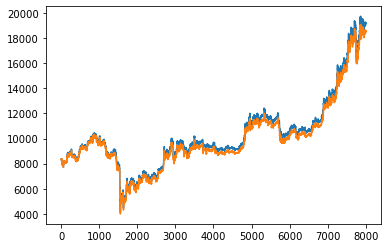

In [213]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

300K


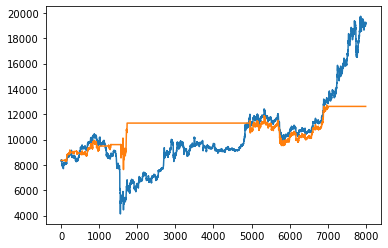

In [565]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


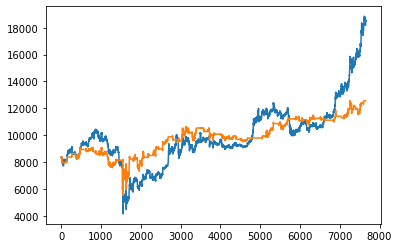

In [995]:
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

### Model test 1: multiple binary classification

##### Approximated USDT assets

In [ ]:
set1 = set([_.replace('BTC','') for _ in klmngr.select(['BTC'], method='quote').sortedkeys()])
set2 = set([_.replace('USDT','') for _ in klmngr.select(['USDT'], method='quote').sortedkeys()])

In [ ]:
assets_features = klmngr.select([_+'USDT' for _ in list(set1&set2)], method='asset')

In [ ]:
np.mean([len(_) for _ in assets_features.listedvalues()])

In [ ]:
for asset in [_.replace('USDT','') for _ in assets_features.sortedkeys()]:
    new_close = (klmngr[asset+'BTC'].close*klmngr['BTCUSDT'].close).dropna()
    new_asset = assets_features[asset+'USDT'].merge(new_close, how='right', left_index=True, right_index=True)
    new_asset = new_asset.drop('close_x',1).rename(columns={'close_y':'close'})
    assets_features[asset+'USDT'] = new_asset

In [ ]:
np.mean([len(_) for _ in assets_features.listedvalues()])

##### Partitioning

In [282]:
asset = 'TRXUSDT'

In [283]:
test_period = klmngr[asset].daily.index.values[-round(len(klmngr[asset].daily)*0.3):]

In [284]:
train_period = klmngr[asset].daily.loc[~klmngr[asset].daily.index.isin(test_period)].close.dropna().index

In [285]:
[round(len(klmngr[asset].daily.loc[_,:])/len(klmngr[asset].daily),2) for _ in [train_period,test_period]]

[0.7, 0.3]

##### Constants

In [286]:
max_timeshift = 30
window = 7*3
half_window = int(round(window/2))

###### Features & targets

In [287]:
all_features_train = np.ndarray((0, 1558))
all_targets_train = np.ndarray((0))

tmp_fa = np.ndarray((0))
tmp_deriv = np.ndarray((0))
tmp_len = np.ndarray((0))
tmp_k = np.ndarray((0))

In [193]:
# More variables: open, high, close ?
# Different/multiple max_timeshift ?
# Different target window?
# Different target alltoghether?

In [288]:
assets_features = klmngr

In [289]:
n_jobs = 6
cols = ['close', 'volume']
i = 0
for asset in tqdm(assets_features.sortedkeys()):
    
    ### Features
    # Define k
    scaler = StandardScaler()
    k = assets_features[asset].daily.copy()
    matching_index = sorted(set(k.index) & set(train_period))
    if (k.index.min() >= train_period.max()) or (len(matching_index) < max_timeshift+1):
        continue
    k = k.loc[matching_index,:]
    k = k.asfreq('D')
    k[cols] = k[cols].fillna(method='ffill')
    k[cols] = scaler.fit_transform(k[cols])
    k.loc[:,'sort'] = k.index.values
    k.loc[:,'id'] = 1
    
    # Make rolling duplications to produce windows 
    raw_signals = k.loc[:,['sort', 'id']+cols]
    rename_dict = dict(zip(range(len(cols)+2), ['sort', 'id']+cols))
    raw_signals = pd.DataFrame(raw_signals.values).rename(columns=rename_dict)
    df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals,
                                                                 column_id='id',
                                                                 column_sort='sort',
                                                                 column_kind=None,
                                                                 rolling_direction=1,
                                                                 max_timeshift=max_timeshift,
                                                                 n_jobs=n_jobs,
                                                                 disable_progressbar=True).reset_index(drop=True)
    
    # Drop windows with less than X periods
    size_per_id = df_roll.groupby('id').size().reset_index()
    df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=max_timeshift+1,:].drop(0, axis=1))
    df_roll = df_roll.astype({'close': 'float'})
    
    # Extract features per window and impute
    # y = df_roll.merge(k['close'].shift(-1).rename('y'), left_on='sort', right_index=True).set_index('id').y.fillna(method='ffill')
    # extracted_features = tsf.extract_relevant_features(df_roll, y, column_id='id', column_sort='sort', disable_progressbar=False)
    df_roll.iloc[:, -len(cols):] = df_roll.iloc[:, -len(cols):].astype(float)
    extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort', n_jobs=n_jobs, disable_progressbar=True)
    extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)
    extracted_features.index = extracted_features.index.droplevel(0)
    
    ### Target
    # Redfine k as it needs to grab future info not present in the training
    k = assets_features[asset].daily.copy()
    k = k.asfreq('D')
    k[cols] = k[cols].fillna(method='ffill')
    k[cols] = scaler.transform(k[cols])
    # Compute target per window
    y = future_average = k.close.rolling(window).mean().shift(-half_window)
    deriv_1 = (y-y.shift(1))/np.repeat(1, len(y))
    target_mask = ((deriv_1 > 0) &
                   (deriv_1.shift(1) <= 0) &
                   (deriv_1.rolling(21).mean().shift(-21) > 0.0075) & #21 0.0025
                   (deriv_1.rolling(14).mean().shift(1) <= 0.01))
    target = target_mask.rename('target')
    target = pd.DataFrame(target.loc[extracted_features.index])
    target = target.assign(id=target.index.values)
    
    ### NaN
    target = target.dropna()
    extracted_features = extracted_features.loc[target.index,:]
    
    ### Add to receptacles
    all_features_train=np.append(all_features_train, extracted_features.values,0)
    all_targets_train=np.append(all_targets_train, target.target.values)
    
    tmp_k = np.append(tmp_k, k.loc[extracted_features.index,:].close.values)
    tmp_fa = np.append(tmp_fa, y.loc[extracted_features.index].values)
    tmp_deriv = np.append(tmp_deriv, deriv_1.loc[extracted_features.index].values)
    tmp_len = np.append(tmp_len, np.repeat(i,len(extracted_features)))
    i+=1

  0%|          | 0/24 [00:00<?, ?it/s]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft_coeffici

  8%|▊         | 2/24 [00:19<03:33,  9.70s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 12%|█▎        | 3/24 [00:33<04:05, 11.69s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 17%|█▋        | 4/24 [00:49<04:19, 12.97s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 21%|██        | 5/24 [00:56<03:32, 11.20s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 25%|██▌       | 6/24 [01:18<04:25, 14.73s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 29%|██▉       | 7/24 [01:28<03:44, 13.22s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 33%|███▎      | 8/24 [01:44<03:43, 13.99s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr

 42%|████▏     | 10/24 [02:09<03:06, 13.34s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft

 46%|████▌     | 11/24 [02:33<03:27, 15.95s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

 50%|█████     | 12/24 [02:54<03:28, 17.39s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft

 54%|█████▍    | 13/24 [03:10<03:05, 16.83s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

 58%|█████▊    | 14/24 [03:30<02:57, 17.77s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

 62%|██████▎   | 15/24 [03:50<02:45, 18.44s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft

 67%|██████▋   | 16/24 [04:11<02:34, 19.34s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

 75%|███████▌  | 18/24 [04:33<01:33, 15.57s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft

 83%|████████▎ | 20/24 [04:57<00:56, 14.08s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['volume__fft_coefficient__attr_"real"__coeff_16'
 'volume__fft_coefficient__attr_"real"__coeff_17'
 'volume__fft_coefficient__attr_"real"__coeff_18'
 'volume__fft_coefficient__attr_"real"__coeff_19'
 'volume__fft_coefficient__attr_"real"__coeff_20'
 'volume__fft_coefficient__attr_"real"__coeff_21'
 'volume__fft_coefficient__attr_"real"__coeff_22'
 'volume__fft_coefficient__attr_"real"__coeff_23'
 'volume__fft_coefficient__attr_"real"__coeff_24'
 'volume__fft_coefficient__attr_"real"__coeff_25'
 'volume__fft_coefficient__attr_"real"__coeff_26'
 'volume__fft_coefficient__attr_"real"__coeff_27'
 'volume__fft_coefficient__attr_"real"__coeff_28'
 'volume__fft_coefficient__attr_"real"__coeff_29'
 'volume__fft_coefficient__attr_"real"__coeff_30'
 'volume__fft_coefficient__attr_"real"__coeff_31'
 'volume__fft

 88%|████████▊ | 21/24 [05:15<00:45, 15.01s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

 92%|█████████▏| 22/24 [05:38<00:33, 16.86s/it]C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__att

100%|██████████| 24/24 [05:47<00:00, 14.49s/it]


In [290]:
i=0

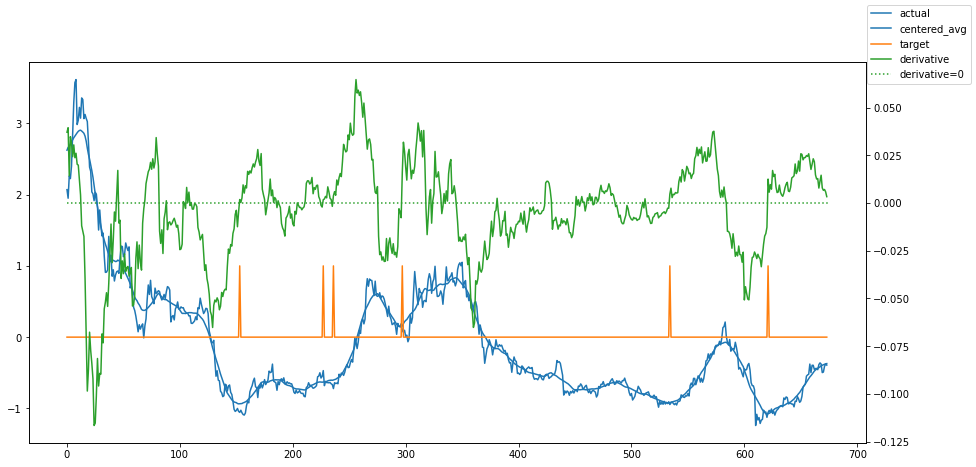

In [291]:
fig, ax = plt.subplots(figsize=(15,7))
ax2 = ax.twinx()
a = ax.plot(tmp_k[tmp_len == np.unique(tmp_len)[i]], color='C0')
b = ax.plot(tmp_fa[tmp_len == np.unique(tmp_len)[i]], color='C0')
c = ax.plot(all_targets_train[tmp_len == np.unique(tmp_len)[i]], color='C1')
d = ax2.plot(tmp_deriv[tmp_len == np.unique(tmp_len)[i]], color='C2')
e = ax2.hlines(0,0,len(tmp_fa[tmp_len == np.unique(tmp_len)[i]]),linestyle=':', color='C2')
i += 1
fig.legend(('actual','centered_avg','target','derivative','derivative=0'))

In [292]:
all_selected_features_train = tsf.select_features(
    pd.DataFrame(all_features_train, columns=pd.Series(range(all_features_train.shape[1])).astype(str)),
    all_targets_train.astype(bool))

In [293]:
all_features_train.shape

(9931, 1558)

In [294]:
all_selected_features_train.shape

(9931, 61)

In [295]:
selected_columns=all_selected_features_train.columns

In [296]:
all_selected_features_train=all_selected_features_train.values

##### Fit

In [297]:
clf = VotingClassifier([('clf1', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=5)),
                        ('clf2', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=5)),
                        ('clf3', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=5)),
                        ('clf5', CalibratedClassifierCV(KNeighborsClassifier(), cv=5)),
                        ('clf7', CalibratedClassifierCV(GaussianNB(), cv=5)),
                        ('clf8', CalibratedClassifierCV(LogisticRegression(solver='liblinear', max_iter=250), cv=5)),
                       ], voting='soft')

In [298]:
fit=clf.fit(X=all_selected_features_train, y=all_targets_train.astype(bool))

##### Test

In [301]:
asset = 'TRXUSDT'
n_jobs = 6
cols = ['close', 'volume']
i = 0

### Features
# Define k
scaler = StandardScaler()
k = klmngr[asset].daily.copy()
k = k.asfreq('D')
k[cols] = k[cols].fillna(method='ffill')
# k = k.loc[:,:]
scaler.fit(k.loc[train_period, cols])
k[cols] = scaler.transform(k[cols])
k.loc[:,'sort'] = k.index.values
k.loc[:,'id'] = 1

# Make rolling duplications to produce windows 
raw_signals = k.loc[:,['sort', 'id']+cols]
rename_dict = dict(zip(range(len(cols)+2), ['sort', 'id']+cols))
raw_signals = pd.DataFrame(raw_signals.values).rename(columns=rename_dict)
df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals,
                                                             column_id='id',
                                                             column_sort='sort',
                                                             column_kind=None,
                                                             rolling_direction=1,
                                                             max_timeshift=max_timeshift,
                                                             n_jobs=n_jobs,
                                                             disable_progressbar=True).reset_index(drop=True)

# Drop windows with less than X periods
size_per_id = df_roll.groupby('id').size().reset_index()
df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=max_timeshift+1,:].drop(0, axis=1))
df_roll = df_roll.astype({'close': 'float'})

# Extract features per window and impute
df_roll.iloc[:, -len(cols):] = df_roll.iloc[:, -len(cols):].astype(float)
extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort', n_jobs=n_jobs, disable_progressbar=True)
extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)
extracted_features.index = extracted_features.index.droplevel(0)
extracted_features = extracted_features.loc[test_period,:]

### Target
# Redfine k as it needs to grab future info not present in the training
k = klmngr[asset].daily.copy()
k = k.asfreq('D')
k[cols] = k[cols].fillna(method='ffill')
k[cols] = scaler.transform(k[cols])
# Compute trget per window
y = future_average = k.close.rolling(window).mean().shift(-half_window)
deriv_1=(y-y.shift(1))/np.repeat(1,len(y))
target_mask=((deriv_1>0)&
             (deriv_1.shift(1)<=0)&
             (deriv_1.rolling(21).mean().shift(-21)>0.0075)& #21 0.0025
             (deriv_1.rolling(14).mean().shift(1)<=0.01))
target = target_mask.rename('target')
target = pd.DataFrame(target.loc[extracted_features.index])
target = target.assign(id=target.index.values)

### NaN
target = target.dropna()
extracted_features = extracted_features.loc[target.index,:]

### Selected columns
extracted_features = pd.DataFrame(extracted_features.values, columns=pd.Series(range(extracted_features.shape[1])).astype(str)).loc[:,selected_columns]

C:\Users\guill\miniconda3\envs\cryptoast-fresh\lib\site-packages\tsfresh\utilities\dataframe_functions.py:172: RuntimeWarning:

The columns ['close__fft_coefficient__attr_"real"__coeff_16'
 'close__fft_coefficient__attr_"real"__coeff_17'
 'close__fft_coefficient__attr_"real"__coeff_18'
 'close__fft_coefficient__attr_"real"__coeff_19'
 'close__fft_coefficient__attr_"real"__coeff_20'
 'close__fft_coefficient__attr_"real"__coeff_21'
 'close__fft_coefficient__attr_"real"__coeff_22'
 'close__fft_coefficient__attr_"real"__coeff_23'
 'close__fft_coefficient__attr_"real"__coeff_24'
 'close__fft_coefficient__attr_"real"__coeff_25'
 'close__fft_coefficient__attr_"real"__coeff_26'
 'close__fft_coefficient__attr_"real"__coeff_27'
 'close__fft_coefficient__attr_"real"__coeff_28'
 'close__fft_coefficient__attr_"real"__coeff_29'
 'close__fft_coefficient__attr_"real"__coeff_30'
 'close__fft_coefficient__attr_"real"__coeff_31'
 'close__fft_coefficient__attr_"real"__coeff_32'
 'close__fft_coefficient__a

In [302]:
probas_pred = fit.predict_proba(X=extracted_features)[:,1]
# precision, recall, _ = precision_recall_curve(y_true=target.target.values.astype(int)
#                                               , probas_pred=probas_pred)

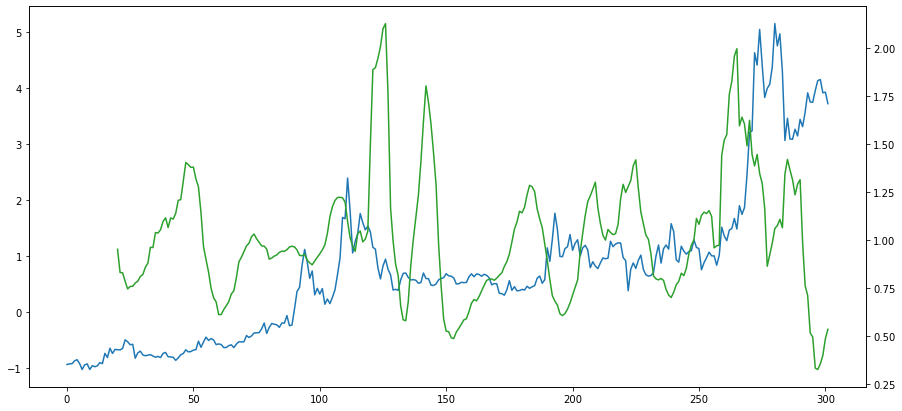

In [303]:
fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
ax.plot(k.loc[test_period,:].close.values, color='C0')
#ax2.plot(pd.Series(probas_pred), color='C1')
#ax2.plot(pd.Series(probas_pred).rolling(21).mean(), color='C2')
ax2.plot(pd.Series(probas_pred).rolling(7).mean()/pd.Series(probas_pred).rolling(21).mean(), color='C2')

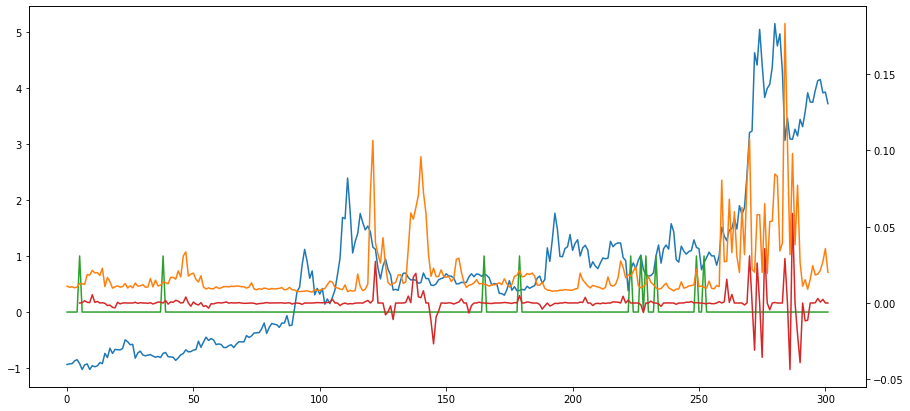

In [304]:
fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
ax.plot(k.loc[test_period,:].close.values, color='C0')
ax.plot(target.target.values, color='C2')
ax2.plot(probas_pred, color='C1')
ax2.plot(pd.Series(probas_pred).rolling(5).median().diff(1), color='C3')

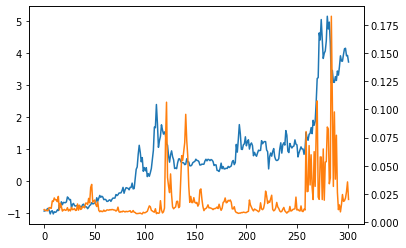

In [396]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(k.loc[test_period,:].close.values)
ax2.plot(probas_pred, color='C1')

In [497]:
frac = .5
sigs = pd.Series(probas_pred > np.quantile(probas_pred, frac)).astype(int)
sigs = pd.Series(np.where(sigs==1, 1, -1), index=target.index).asfreq('H').ffill()
sigs = sigs.where(sigs==1).rolling(24, min_periods=1).max().fillna(sigs)

In [498]:
btst_k = klmngr[asset].loc[sigs.index[0]:]
btst = Backtest(kline=btst_k, init_assets=1)
periodic = btst.run(sigs[1:]*999)

In [489]:
btst_k = klmngr[asset].loc[sigs.index[0]:]
btst = Backtest(kline=btst_k, init_assets=1)
for sig in sigs:
    if sig == 1:
        if btst.periodic.value.pct_change().iloc[-1] < -.01:
            btst.step(-1*999)
        else:
            btst.step(1*999)
        continue
    else:
        btst.step(0*999)
        continue

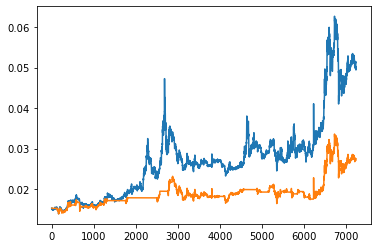

In [499]:
plt.plot(btst_k.close.values)
plt.plot(btst.periodic.value.values)

In [38]:
probas_pred2=(pd.Series(probas_pred).rolling(7).mean()/pd.Series(probas_pred).rolling(21).mean()).fillna(0).values

In [39]:
k=klmngr[asset]

In [40]:
# BUY & SELL based on target movements
positions=dict()
funds_usdt_equivalent_dic = dict()

thresholds = np.unique(np.sort(np.unique(probas_pred2)).round(2))
for threshold in thresholds:
    positions[threshold]=[]
    start_funds = 1000
    funds = start_funds
    funds_usdt_equivalent = [funds]
    position = 'USDT'
    for i, day in enumerate(target.index):
        positions[threshold].append(position)
        if probas_pred2[i]>=threshold:
            if position == 'USDT':
                funds = funds/k.loc[day, 'close']
                position = 'BTC'
        else:
            if position != 'USDT':
                funds = funds*k.loc[day, 'close']
                position = 'USDT'
        usdt_equivalent = funds if position == 'USDT' else funds*k.loc[day, 'close']
        #print(i, day, usdt_equivalent)
        funds_usdt_equivalent.append(usdt_equivalent)
    funds_usdt_equivalent_dic[threshold] = funds_usdt_equivalent

In [41]:
print("hold posit. :"
      , -1*round(k.loc[test_period, 'close'][0]/min(k.loc[test_period, 'close']), 2)
      , round(max(k.loc[test_period, 'close'])/k.loc[test_period, 'close'][0], 2)
      , round(k.loc[test_period, 'close'][-1]/k.loc[test_period, 'close'][0], 2)
     )

for threshold in thresholds:
    print("proba >= {}".format(threshold), ":"
          , -1*round(funds_usdt_equivalent_dic[threshold][0]/min(funds_usdt_equivalent_dic[threshold]), 2)
          ,    round(max(funds_usdt_equivalent_dic[threshold])/funds_usdt_equivalent_dic[threshold][0], 2)
          ,    round(funds_usdt_equivalent_dic[threshold][-1]/funds_usdt_equivalent_dic[threshold][0],  2)
         )

hold posit. : -1.09 3.73 2.89
proba >= 0.0 : -1.09 3.73 2.89
proba >= 0.73 : -1.11 3.47 2.68
proba >= 0.74 : -1.1 3.5 2.71
proba >= 0.75 : -1.15 3.34 2.59
proba >= 0.76 : -1.09 3.54 2.74
proba >= 0.8 : -1.12 3.45 2.67
proba >= 0.82 : -1.11 3.48 2.69
proba >= 0.85 : -1.11 3.48 2.69
proba >= 0.86 : -1.12 3.45 2.66
proba >= 0.87 : -1.11 3.43 2.64
proba >= 0.88 : -1.12 3.16 2.43
proba >= 0.89 : -1.18 2.98 2.28
proba >= 0.9 : -1.17 3.0 2.47
proba >= 0.91 : -1.18 3.17 2.93
proba >= 0.92 : -1.18 3.0 2.85
proba >= 0.93 : -1.17 2.56 2.43
proba >= 0.94 : -1.17 2.57 2.29
proba >= 0.95 : -1.17 2.48 2.1
proba >= 0.96 : -1.06 2.17 1.63
proba >= 0.97 : -1.07 1.68 1.14
proba >= 0.98 : -1.16 1.59 0.98
proba >= 0.99 : -1.01 1.75 1.4
proba >= 1.0 : -1.08 1.94 1.6
proba >= 1.01 : -1.05 1.9 1.74
proba >= 1.02 : -1.06 2.05 1.87
proba >= 1.03 : -1.01 1.91 1.84
proba >= 1.04 : -1.01 1.65 1.55
proba >= 1.05 : -1.0 1.37 1.28
proba >= 1.06 : -1.0 1.33 1.24
proba >= 1.07 : -1.01 1.31 1.19
proba >= 1.08 : -1.0 1.1

In [42]:
scale = k.loc[test_period, 'close'].values[0]/start_funds

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



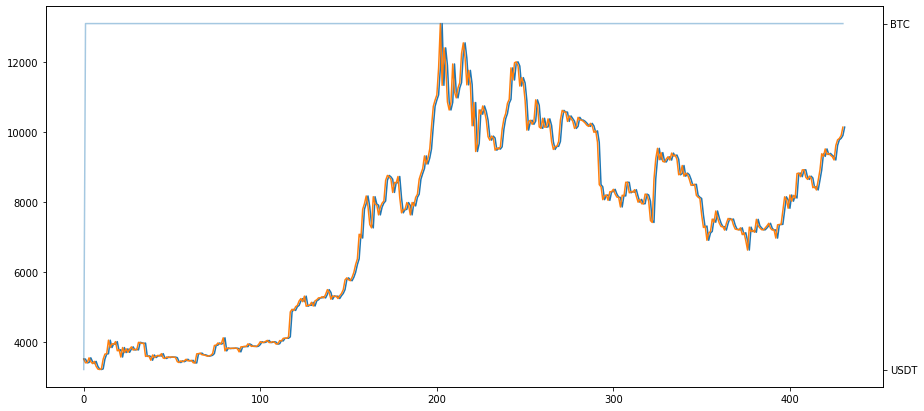

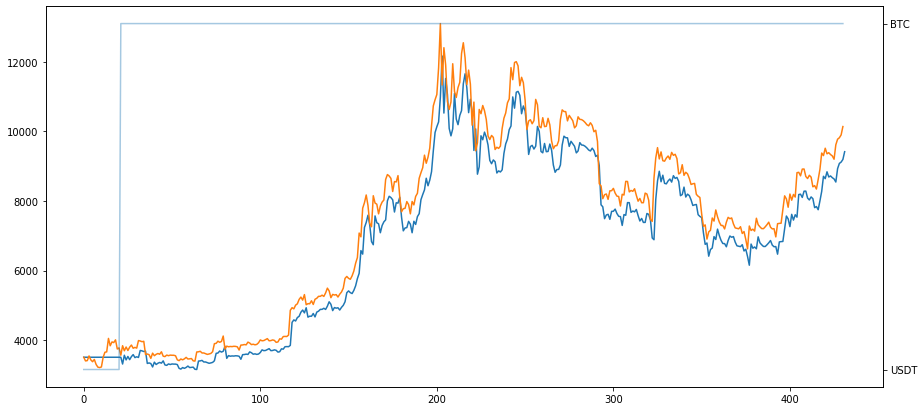

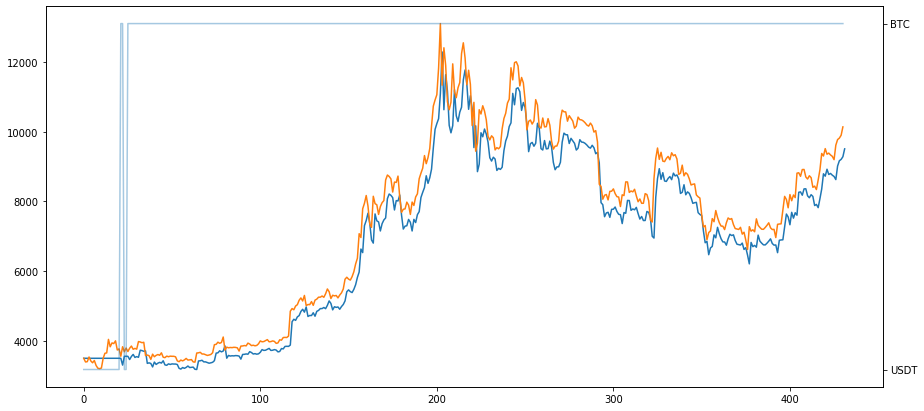

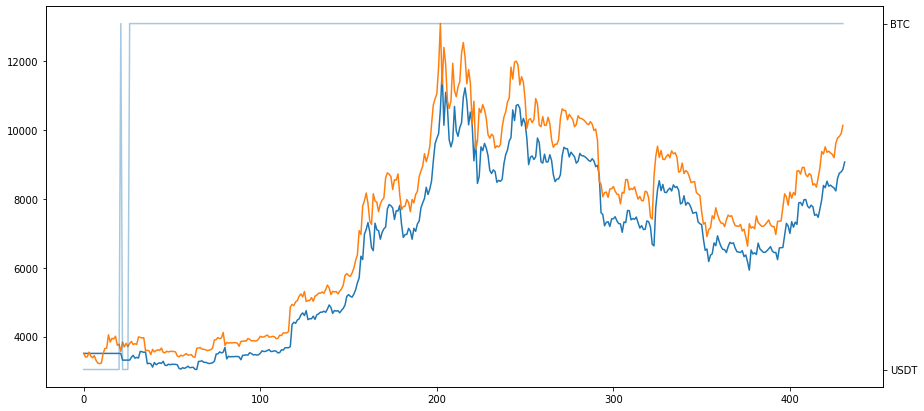

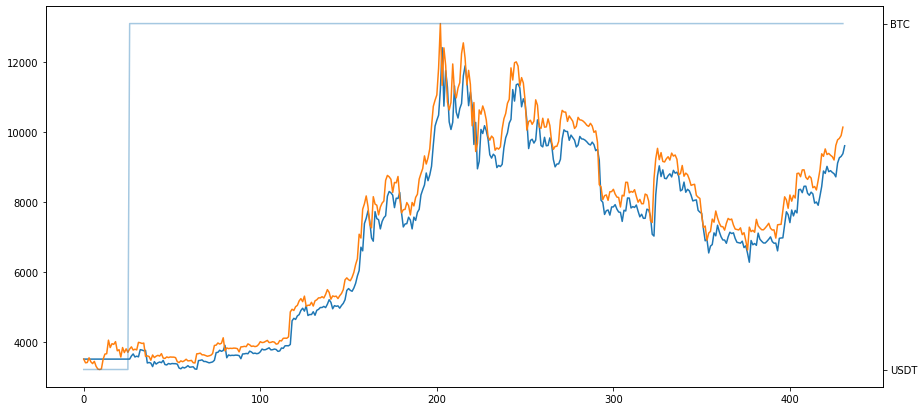

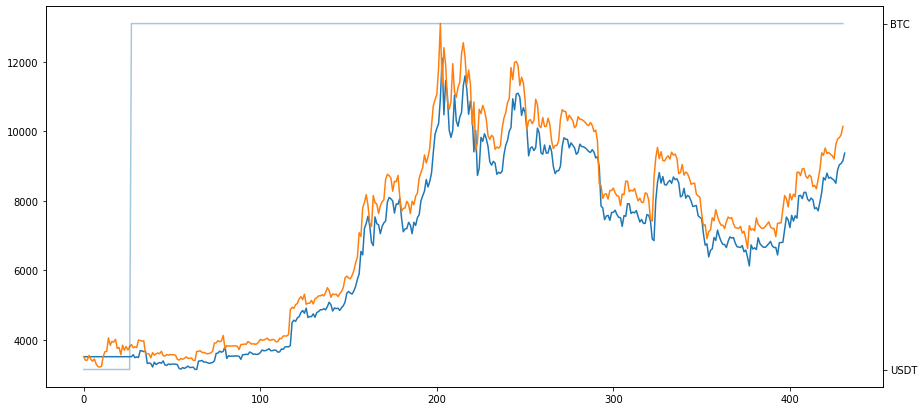

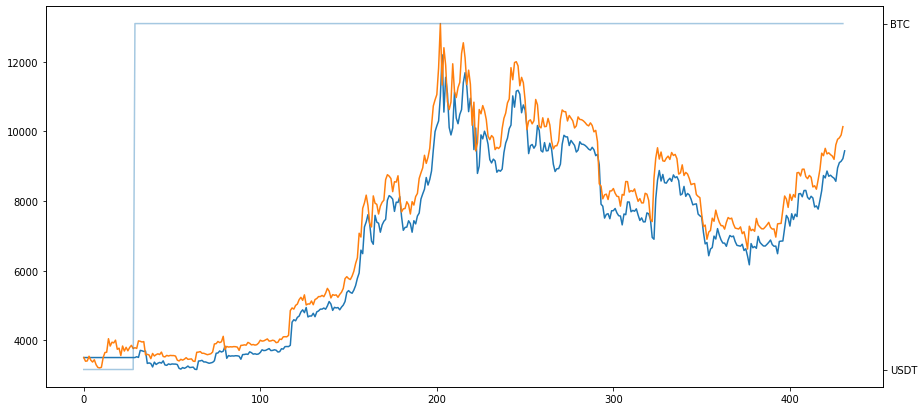

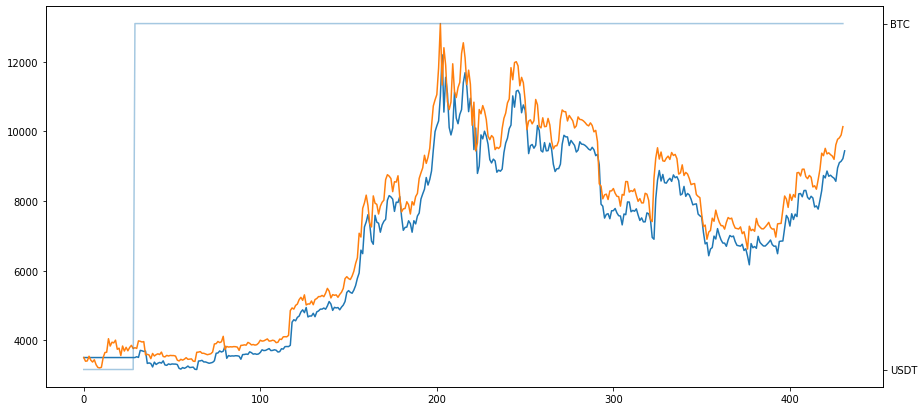

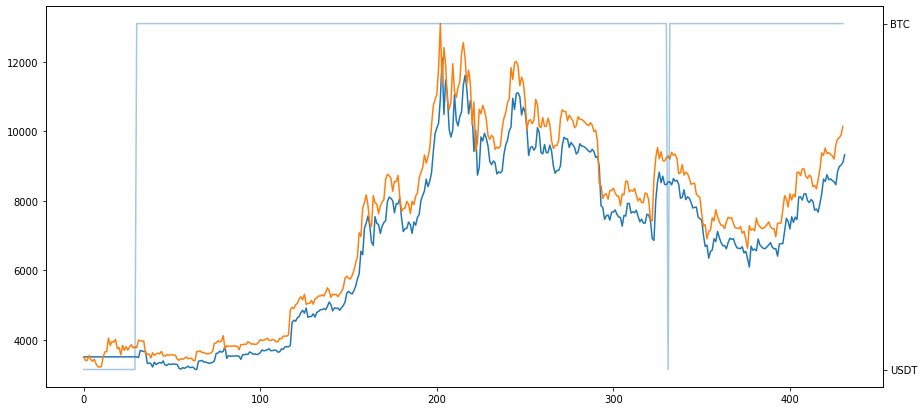

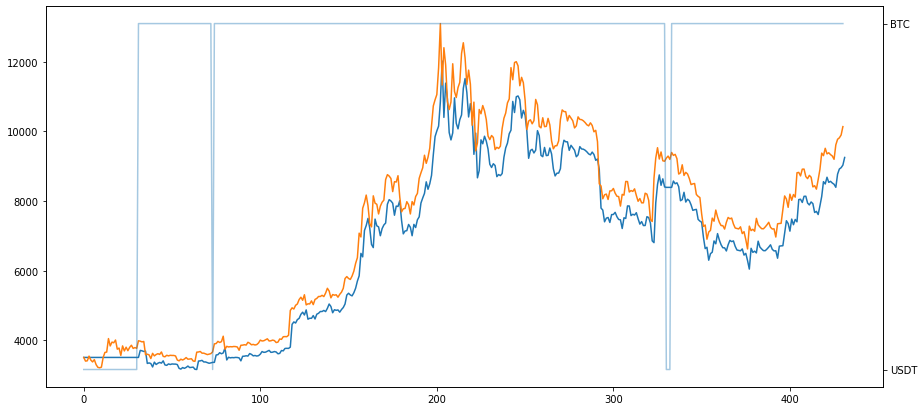

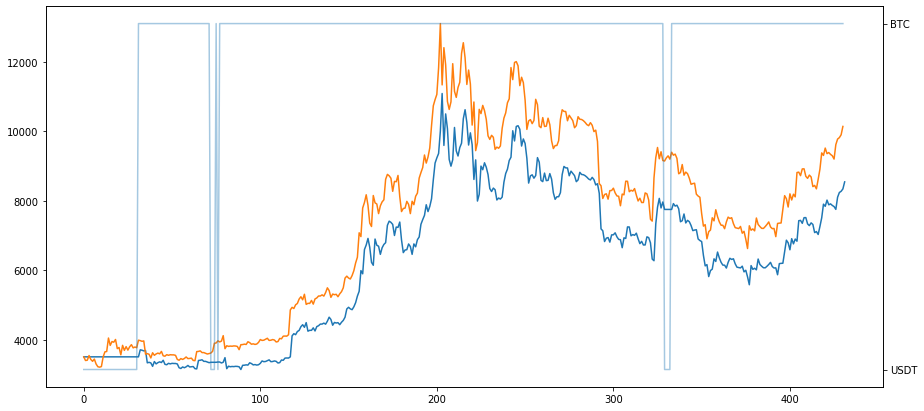

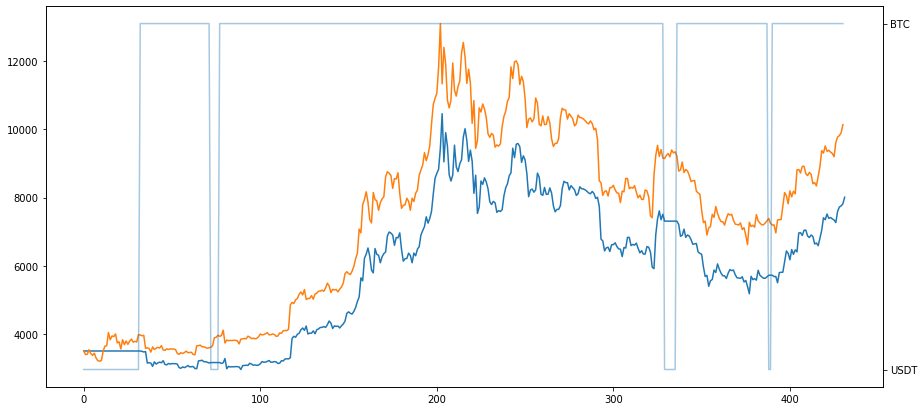

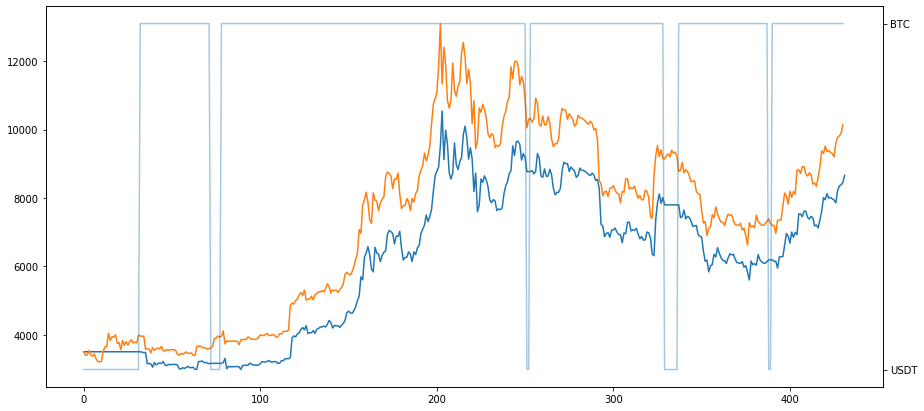

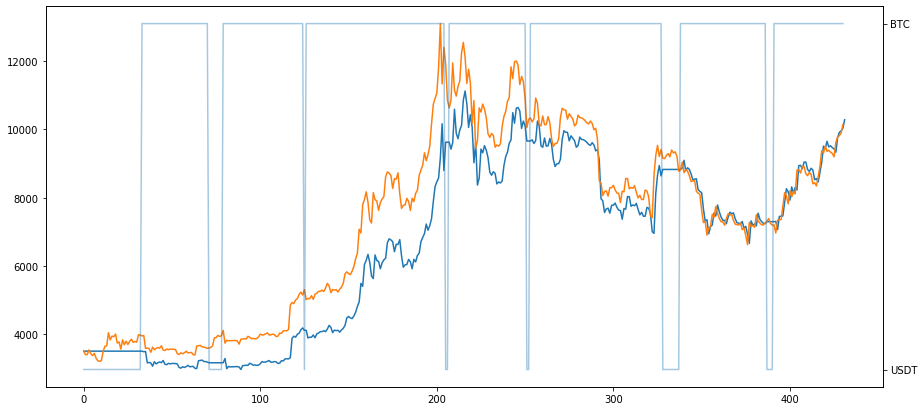

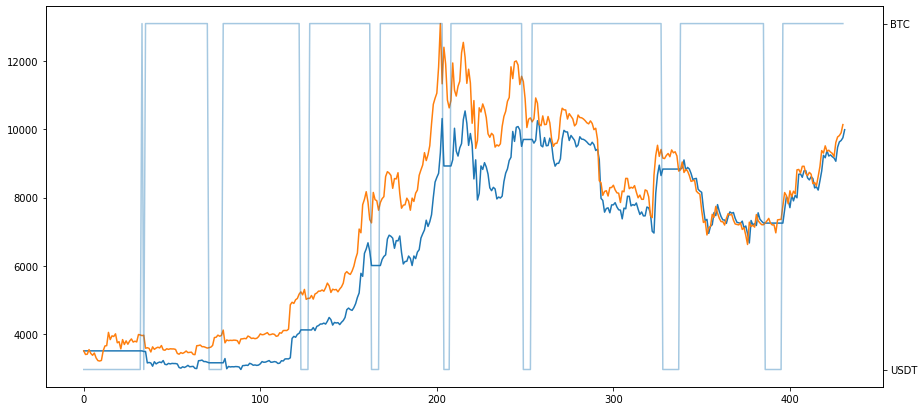

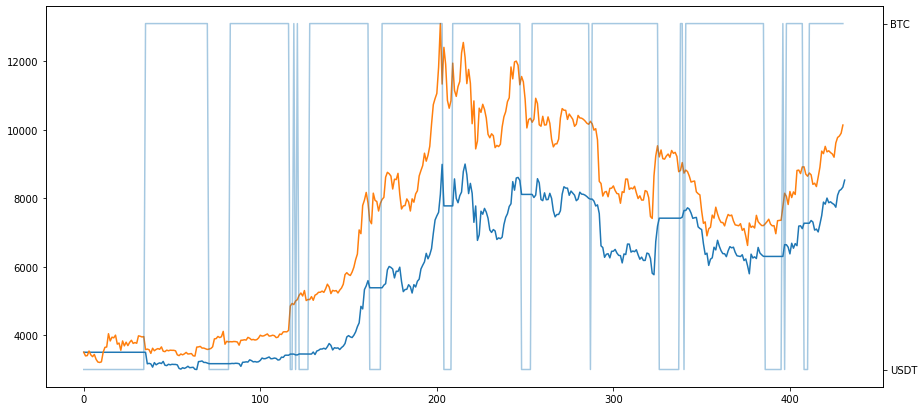

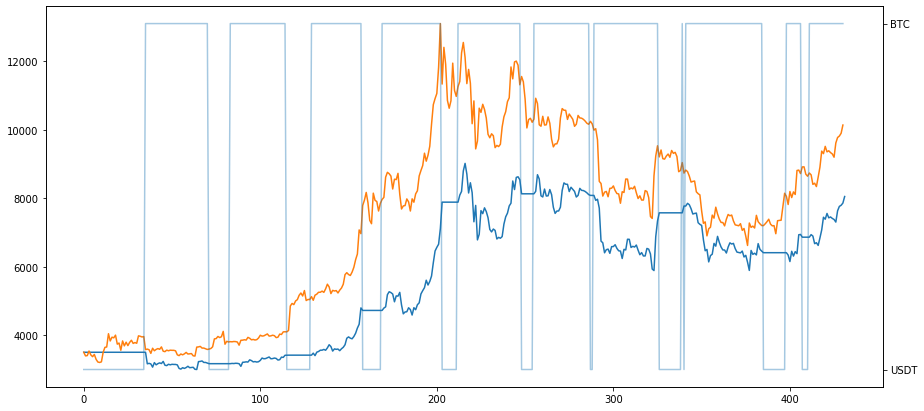

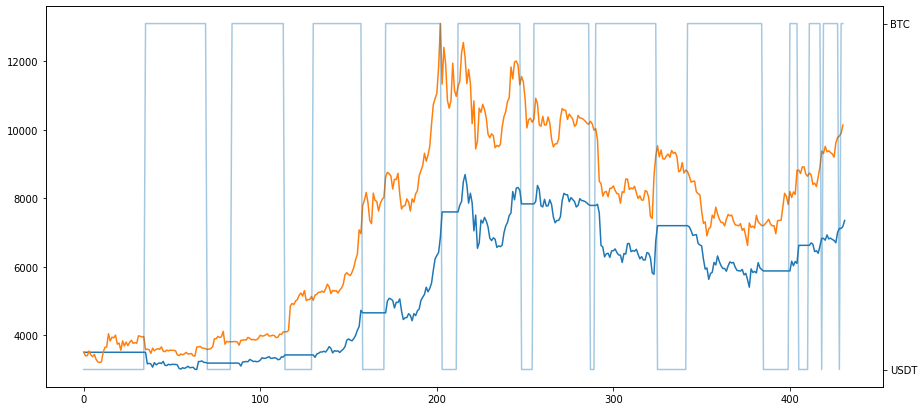

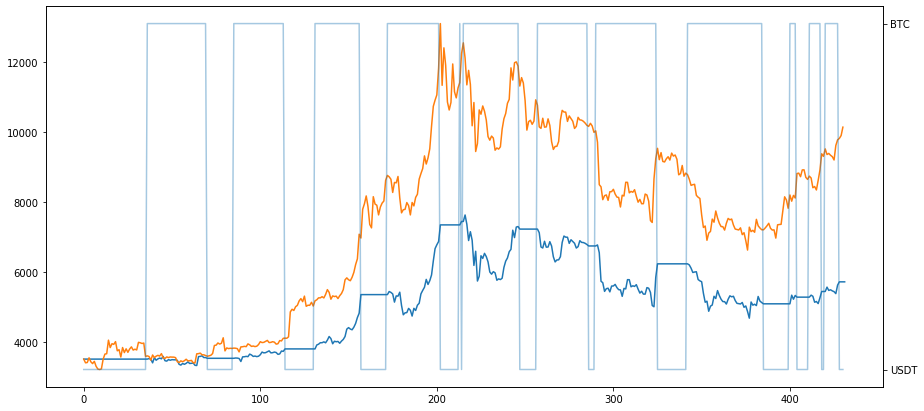

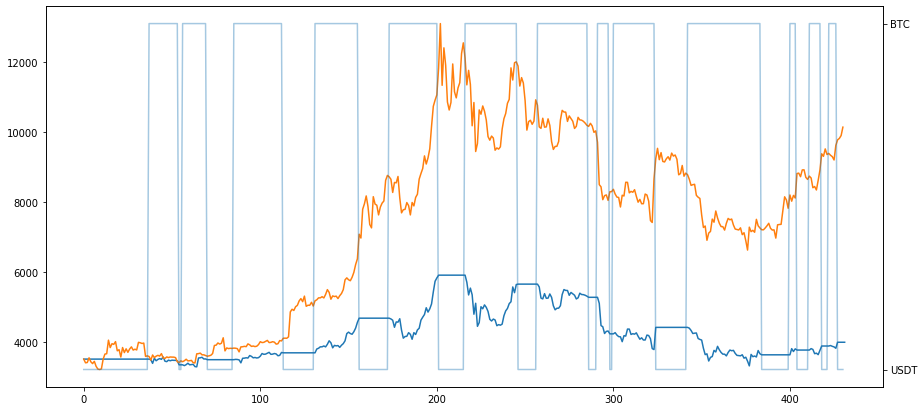

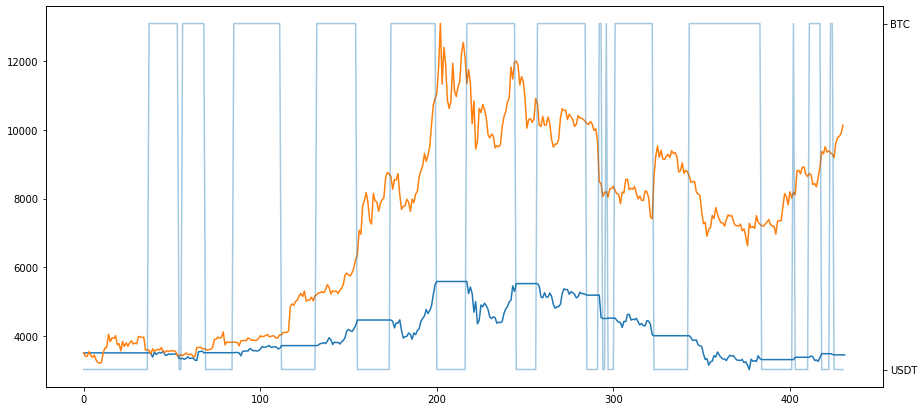

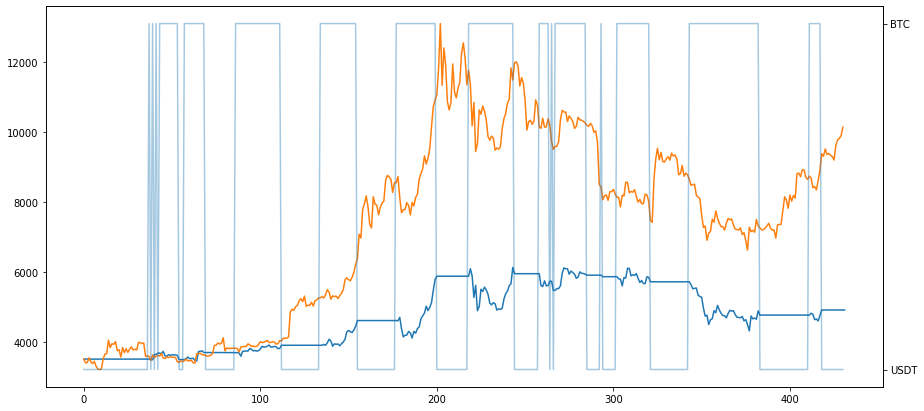

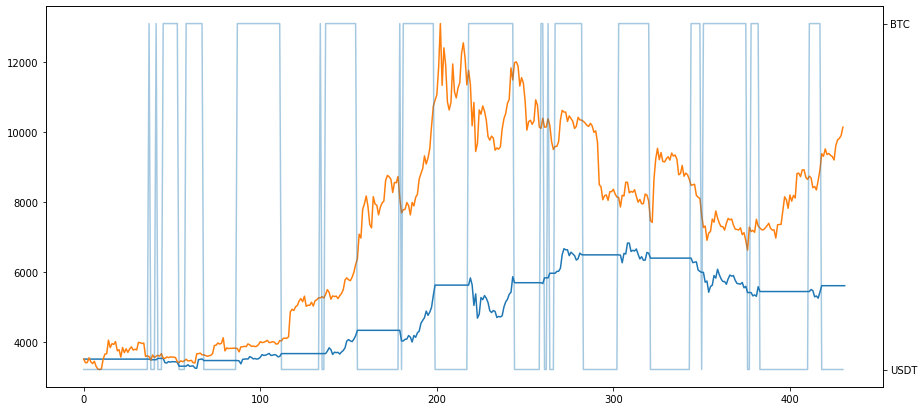

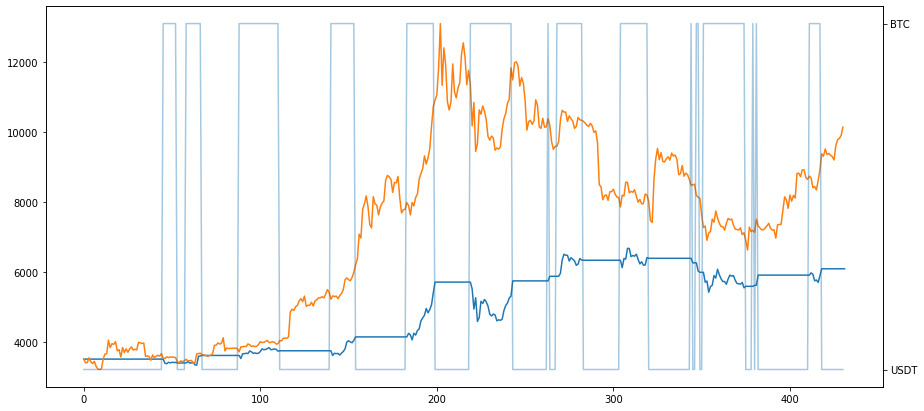

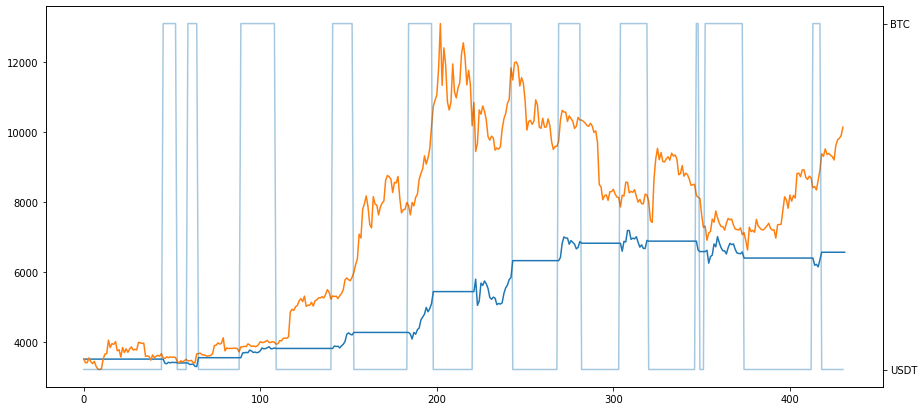

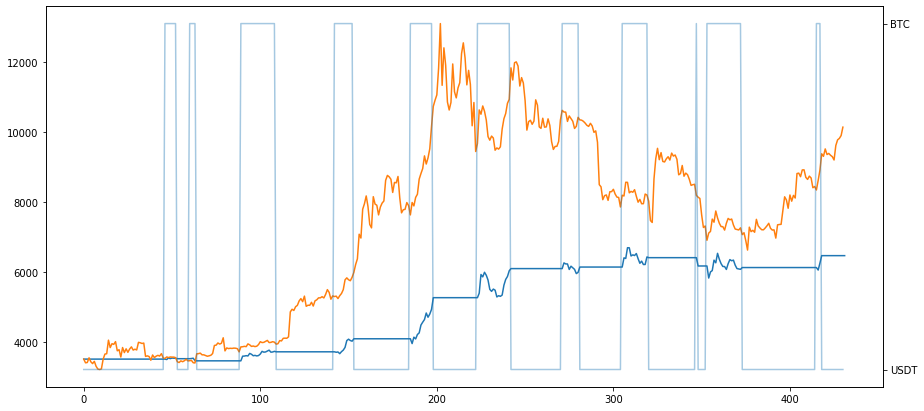

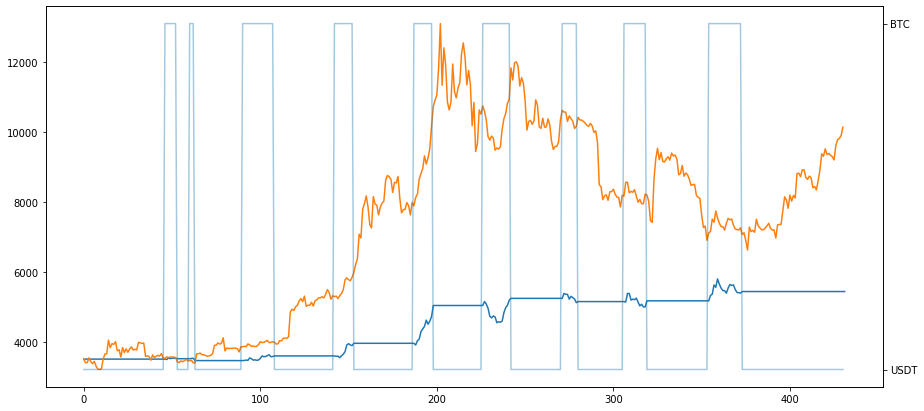

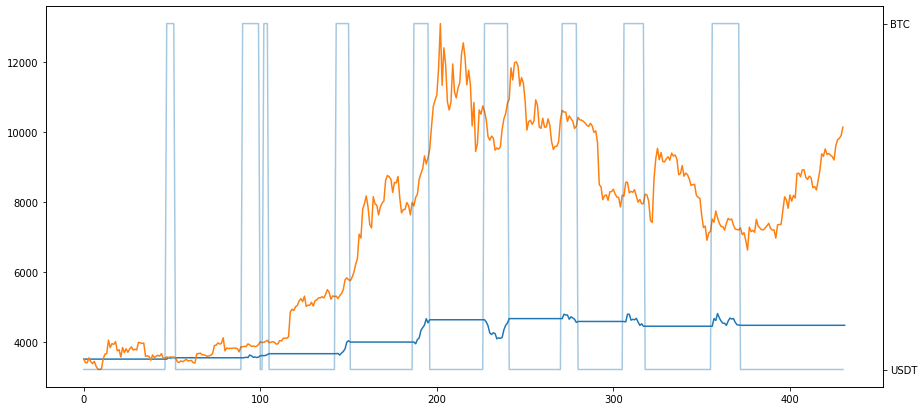

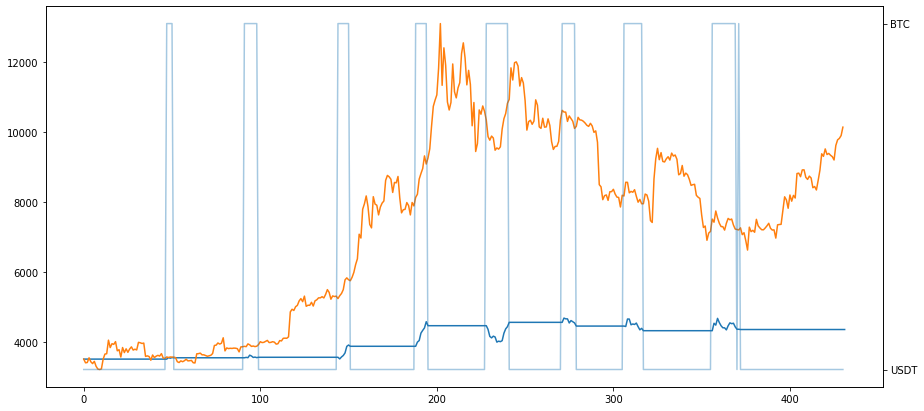

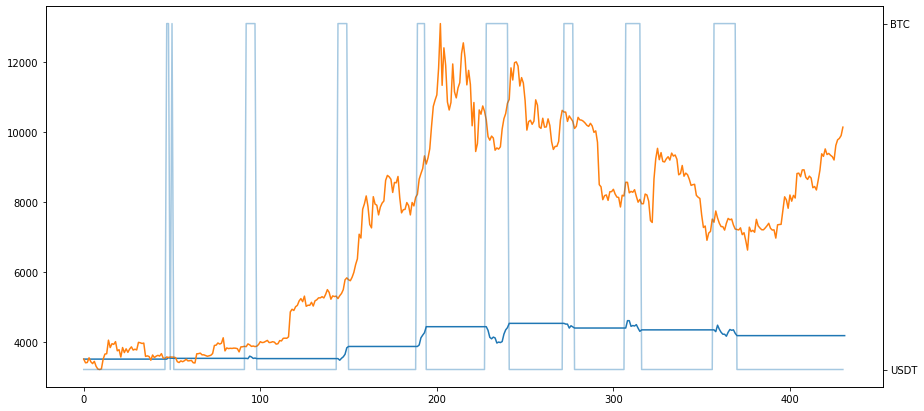

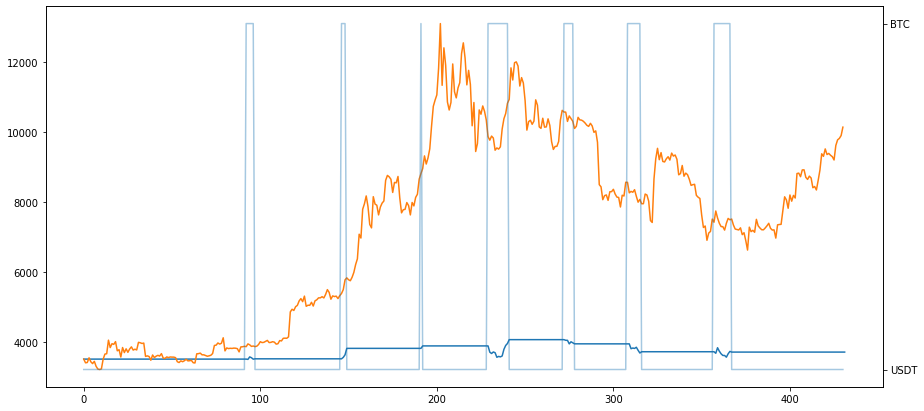

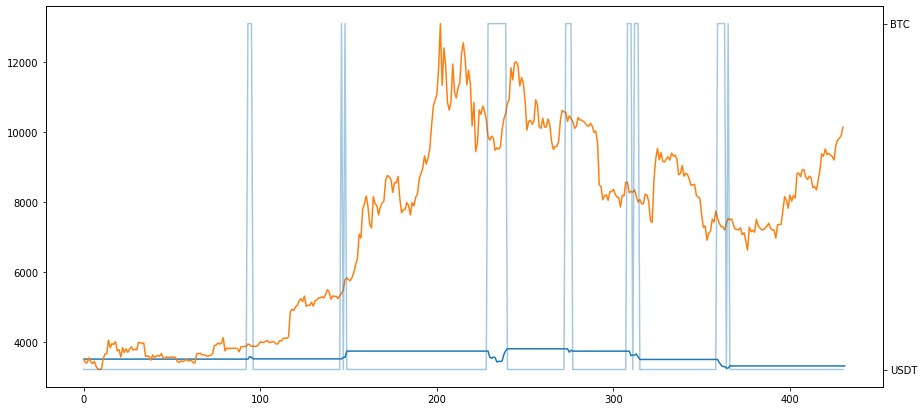

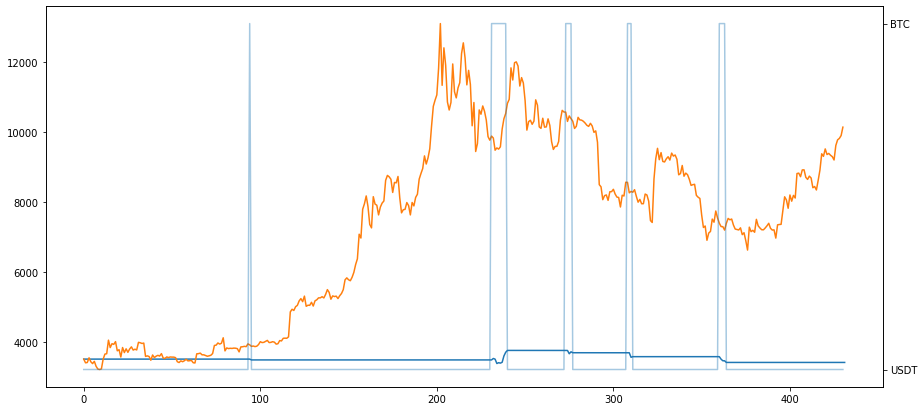

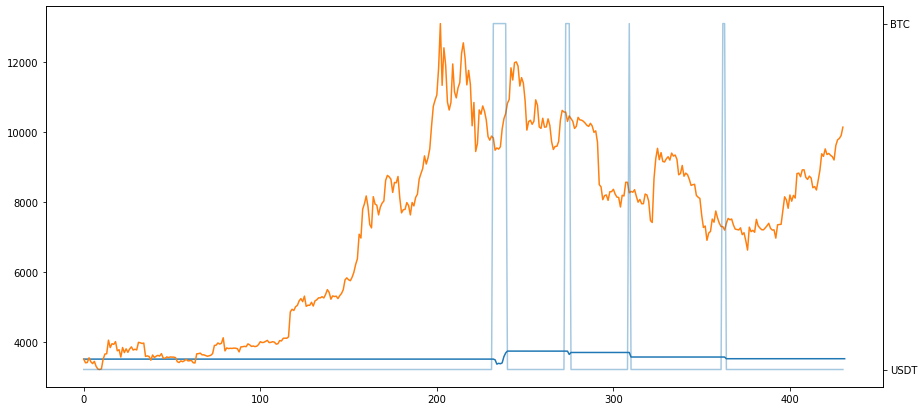

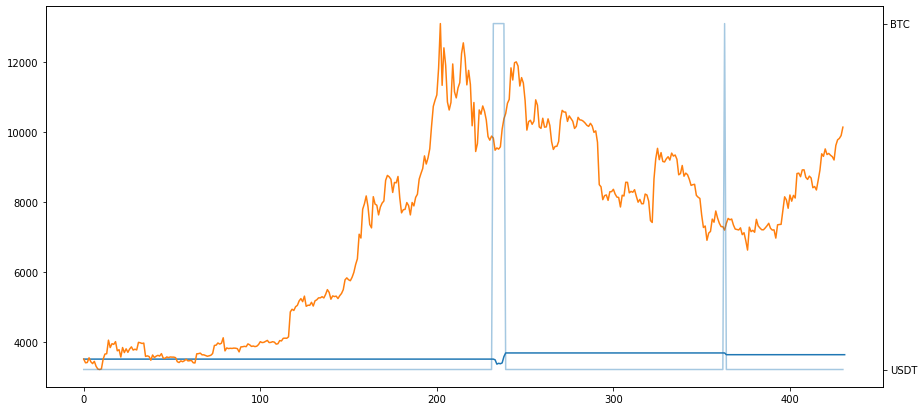

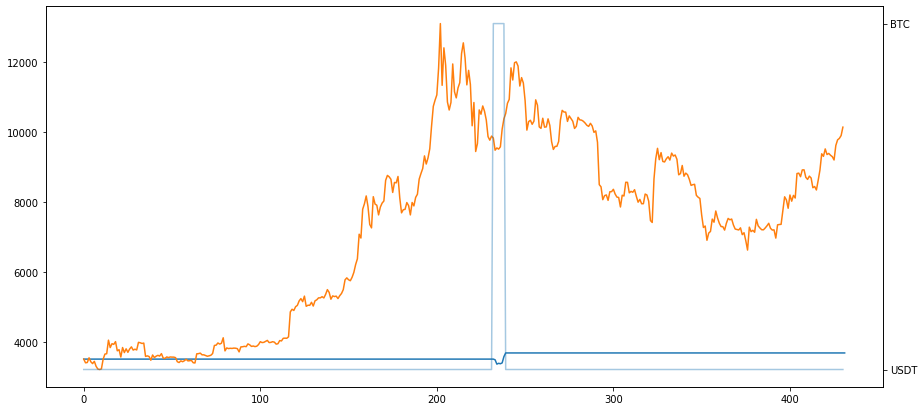

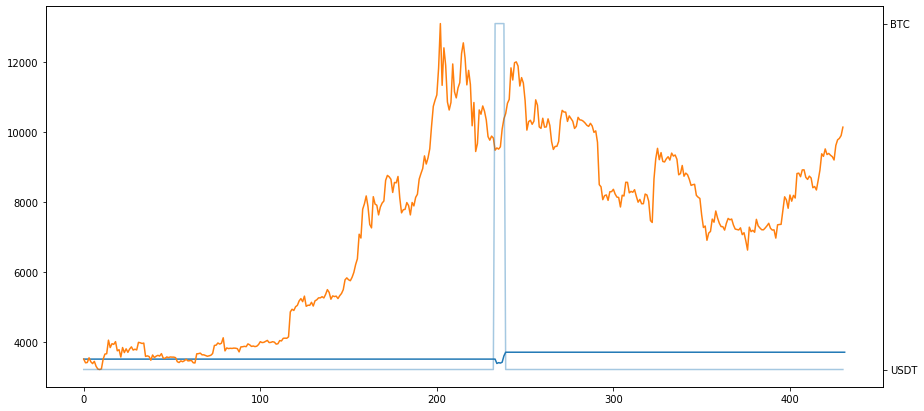

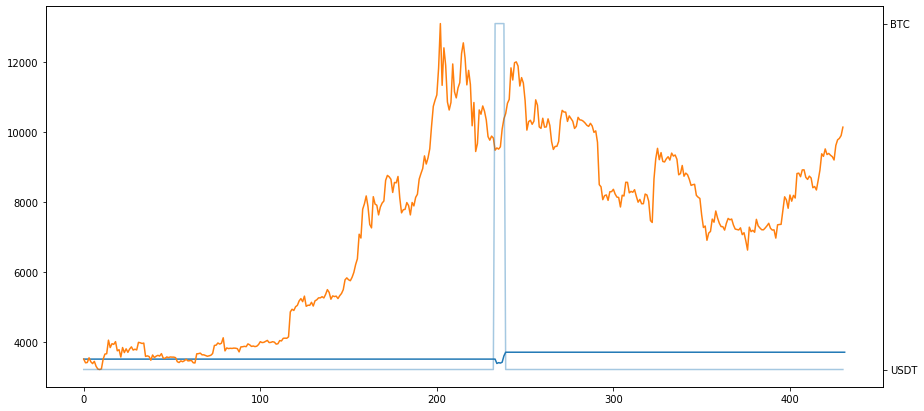

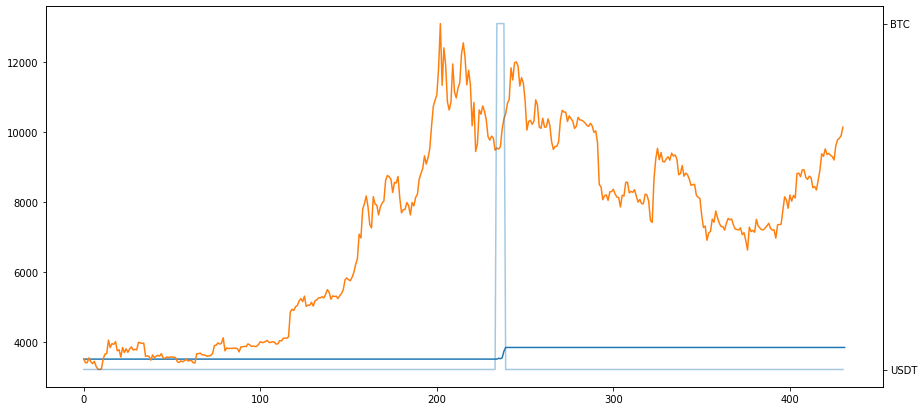

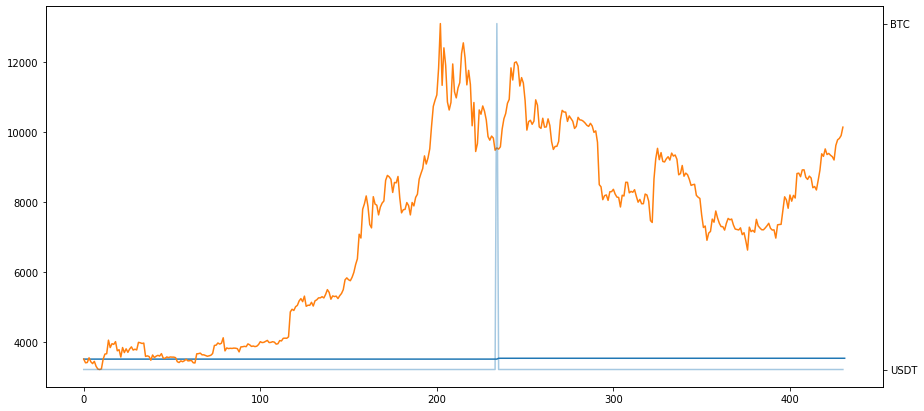

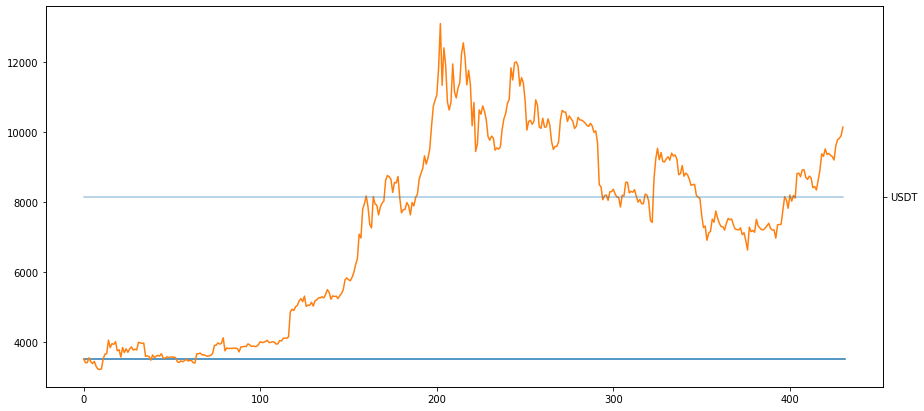

In [43]:
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    ax.plot(np.array(k.loc[test_period, 'close']))
    ax2=ax.twinx()
    ax2.plot(range(len(test_period)),positions[threshold], alpha=.4)

### Model test 2: binary classification

##### Kline and tsfresh columns

In [11]:
asset_features='BTCUSDT'

In [12]:
mngr[asset_features];

In [13]:
k = mngr[asset_features].copy()
k.loc[:,'sort'] = k.index.values
k.loc[:,'id'] = 1

##### Make rolling duplications to produce windows 

In [14]:
raw_signals = k.loc[:,['sort', 'id', 'open','high','low','close']]

In [15]:
df_roll = tsf.utilities.dataframe_functions.roll_time_series(raw_signals
                                                            , column_id='id'
                                                            , column_sort='sort'
                                                            , column_kind=None
                                                            , rolling_direction=1
                                                            , max_timeshift=30).reset_index(drop=True)

##### Drop windows with less than X periods

In [16]:
size_per_id = df_roll.groupby('id').size().reset_index()
df_roll = df_roll.merge(size_per_id, on='id', how='left').pipe(lambda df_roll: df_roll.loc[df_roll.loc[:,0]>=31,:].drop(0, axis=1))

##### Extract features per window and impute

In [17]:
extracted_features = tsf.extract_features(df_roll, column_id='id', column_sort='sort')

Feature Extraction: 100%|██████████████████████| 20/20 [08:11<00:00, 14.56s/it]


In [18]:
extracted_features = tsf.utilities.dataframe_functions.impute(extracted_features)

C:\Users\GUIX\Anaconda3\envs\invest\lib\site-packages\tsfresh\utilities\dataframe_functions.py:164: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.

 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'close__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...
 'open__fft_coefficient__coeff_99__attr_"angle"'
 'open__fft_coefficient__coeff_99__attr_"imag"'
 'open__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


##### Compute target per window

Pits

In [19]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
window = 7*3
half_window = int(round(window/2))
fig.add_trace(go.Scatter(x=k.index,y=k.close))
y = future_average = k.close.rolling(window).mean().shift(-half_window)
fig.add_trace(go.Scatter(x=future_average.index, y=future_average))

deriv_1=(y-y.shift(1))/np.repeat(1,len(y))

target_mask=((deriv_1>0)&
             (deriv_1.shift(1)<0)&
             (deriv_1.rolling(21).mean().shift(-21)>10)& # 0.0025
             (deriv_1.rolling(7).mean()<=0))
fig.add_trace(go.Scatter(x=target_mask.index, y=target_mask.astype(int), mode='none', fill='tozeroy',
                         fillcolor='black', name='target'), secondary_y=True)
target=target_mask.rename('target')

In [20]:
target = pd.DataFrame(target.loc[extracted_features.index])
target = target.assign(id=target.index.values)

##### Select features based on target

In [21]:
selected_features = tsf.select_features(extracted_features.loc[target.id,:], target.target.values)
#selected_features = extracted_features.loc[target.id,:]

In [22]:
train_period = selected_features.index.values[:round(len(selected_features)*0.7)]
test_period = selected_features.loc[~selected_features.index.isin(train_period)].dropna().index

In [127]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [190]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, )

In [ ]:
clf = VotingClassifier([('clf1', CalibratedClassifierCV(GradientBoostingClassifier(n_estimators=100), cv=3)),
                        ('clf2', CalibratedClassifierCV(AdaBoostClassifier(n_estimators=100), cv=3)),
                        ('clf3', CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), cv=3)),
                        ('clf4', CalibratedClassifierCV(ExtraTreesClassifier(n_estimators=100), cv=3)),
                        ('clf5', CalibratedClassifierCV(KNeighborsClassifier(), cv=3)),
                        ('clf7', CalibratedClassifierCV(GaussianNB(), cv=3)),
                        ('clf8', CalibratedClassifierCV(LogisticRegression(solver='lbfgs', max_iter=250), cv=3)),
                       ], voting='soft')

In [191]:
fit=clf.fit(X=selected_features.loc[train_period].values, y=target.loc[train_period, 'target'].values.astype(int));

In [192]:
roc_auc_score(y_true=target.loc[train_period, 'target'].values.astype(int)
              , y_score=fit.predict(X=selected_features.loc[train_period].values))

1.0

In [193]:
roc_auc_score(y_true=target.loc[test_period, 'target'].values.astype(int)
              , y_score=fit.predict(X=selected_features.loc[test_period].values))

0.5

In [194]:
probas_pred = fit.predict_proba(X=selected_features.loc[test_period].values.astype(int))[:,1]
precision, recall, _ = precision_recall_curve(y_true=target.loc[test_period, 'target'].values.astype(int)
                                              , probas_pred=probas_pred)

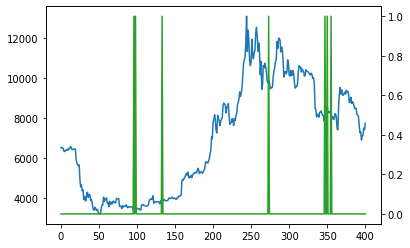

In [195]:
fig,ax=plt.subplots()
ax.plot(k.close.loc[test_period].values, color='C0')
ax2=ax.twinx()
#ax2.plot(probas_pred, color='C1')
ax2.plot(target.target.loc[test_period].astype(int).values, color='C2')

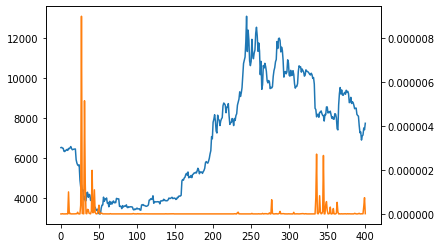

In [196]:
fig,ax=plt.subplots()
ax.plot(k.close.loc[test_period].values, color='C0')
ax2=ax.twinx()
ax2.plot(probas_pred, color='C1')
#ax2.plot(target.target.loc[test_period].astype(int).values, color='C2')

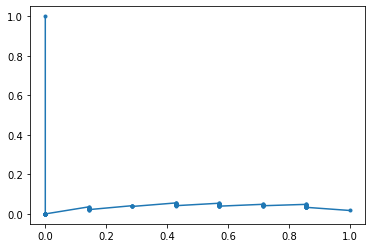

In [31]:
plt.plot(recall, precision, marker='.')

In [186]:
# BUY & SELL following target window

funds_usdt_equivalent_dic = dict()

thresholds = np.sort(np.unique(probas_pred))
#thresholds = thresholds[thresholds>0.5]
thresholds = np.unique(thresholds.round(1))
for threshold in thresholds:
    hold_period = 15
    start_funds = 1000
    funds = start_funds
    funds_usdt_equivalent = [funds]
    position = 'USDT'
    for i, day in enumerate(test_period):
        hold_period = max(0, hold_period-1)
        if probas_pred[i]>=threshold:
            hold_period = 21
        if hold_period > 0:
            if position == 'USDT':
                funds = funds/k.loc[day, 'close']
                position = 'BTC'
        elif position != 'USDT':
            funds = funds*k.loc[day, 'close']
            position = 'USDT'
        usdt_equivalent = funds if position == 'USDT' else funds*k.loc[day, 'close']
        #print(i, day, usdt_equivalent)
        funds_usdt_equivalent.append(usdt_equivalent)
    funds_usdt_equivalent_dic[threshold] = funds_usdt_equivalent

In [187]:
print("hold posit. :"
      , -1*round(k.loc[test_period, 'close'][0]/min(k.loc[test_period, 'close']), 2)
      , round(max(k.loc[test_period, 'close'])/k.loc[test_period, 'close'][0], 2)
      , round(k.loc[test_period, 'close'][-1]/k.loc[test_period, 'close'][0], 2)
     )

for threshold in thresholds:
    print("proba >= {}".format(threshold), ":"
          , -1*round(funds_usdt_equivalent_dic[threshold][0]/min(funds_usdt_equivalent_dic[threshold]), 2)
          ,    round(max(funds_usdt_equivalent_dic[threshold])/funds_usdt_equivalent_dic[threshold][0], 2)
          ,    round(funds_usdt_equivalent_dic[threshold][-1]/funds_usdt_equivalent_dic[threshold][0],  2)
         )

hold posit. : -1.95 2.09 1.41
proba >= 0.0 : -1.95 2.09 1.41
proba >= 0.1 : -1.95 2.09 1.41
proba >= 0.2 : -1.95 2.09 1.41
proba >= 0.3 : -1.95 2.09 1.41
proba >= 0.4 : -1.95 2.09 1.64
proba >= 0.5 : -1.95 2.09 1.76
proba >= 0.6 : -1.95 2.22 2.05
proba >= 0.7 : -1.96 1.98 1.81
proba >= 0.8 : -1.94 1.92 1.75
proba >= 0.9 : -1.21 2.24 1.67
proba >= 1.0 : -1.0 1.08 1.04


In [188]:
scale = k.loc[test_period, 'close'].values[0]/start_funds

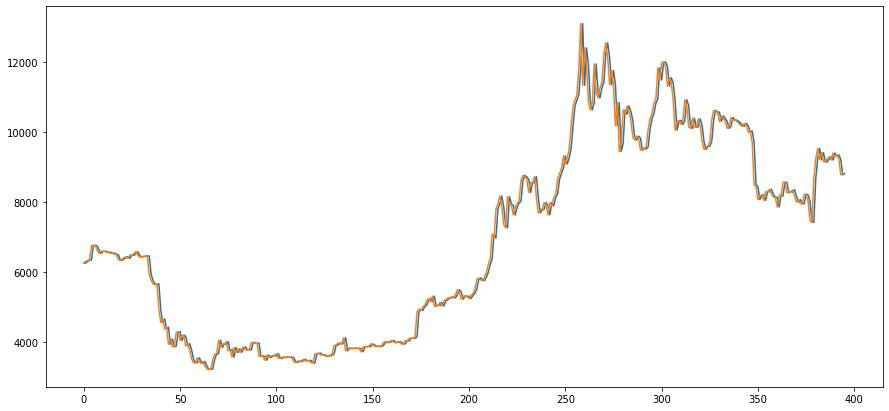

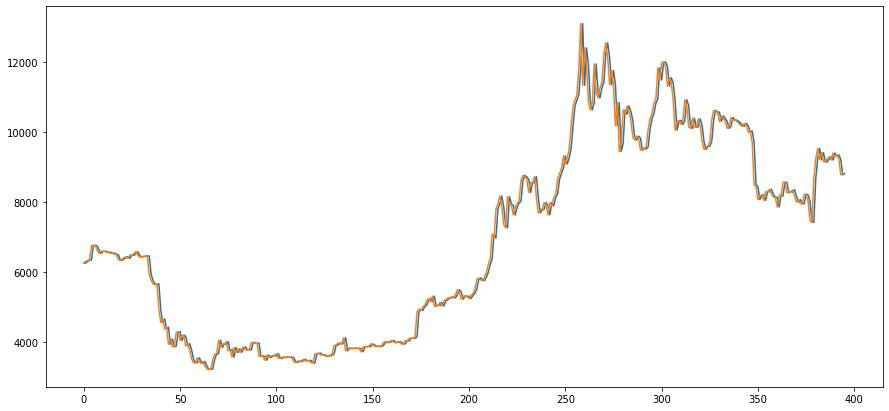

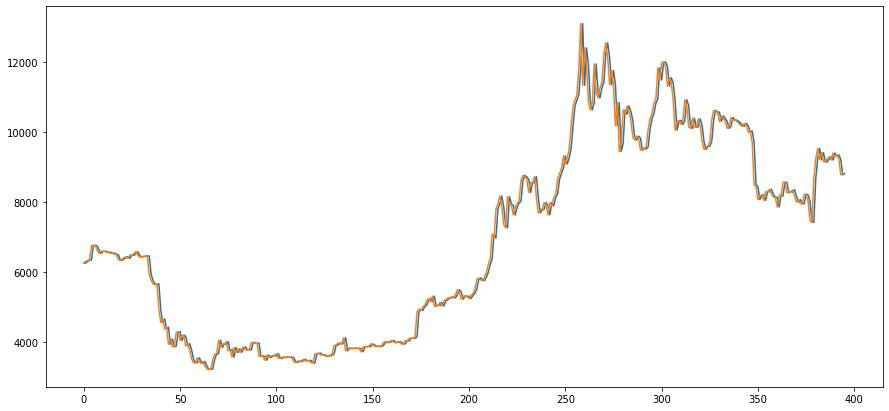

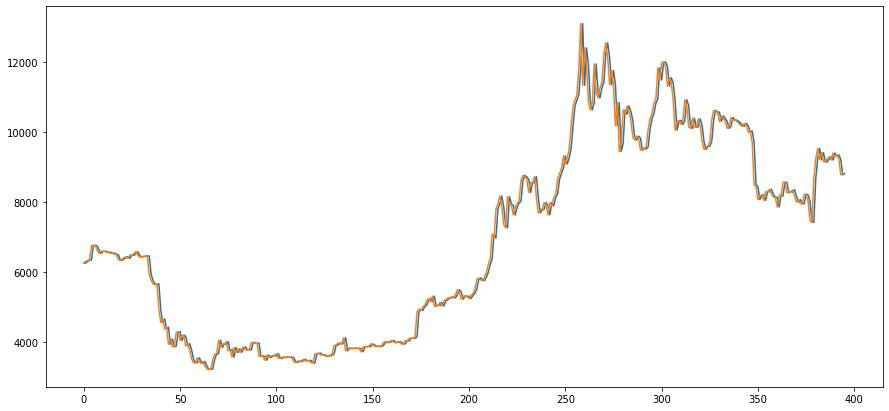

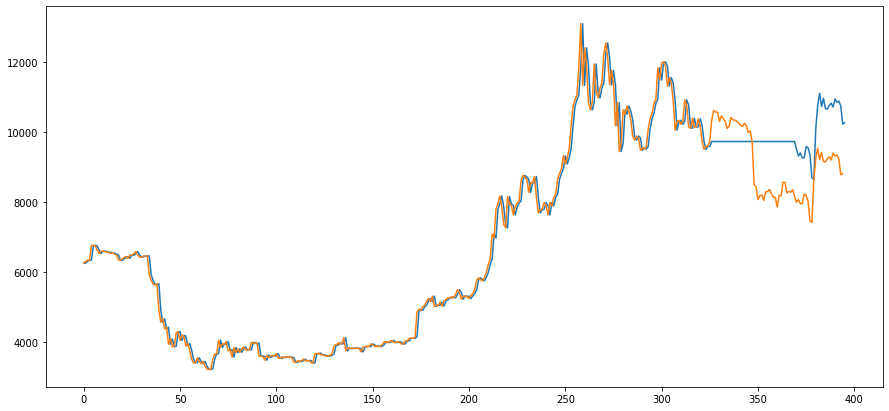

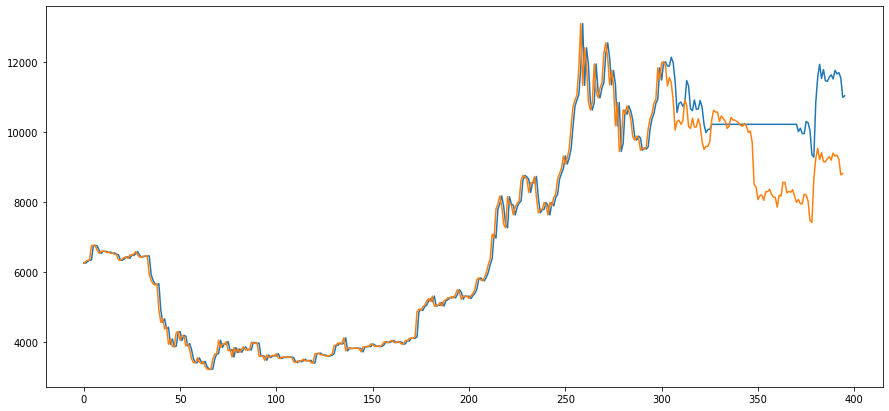

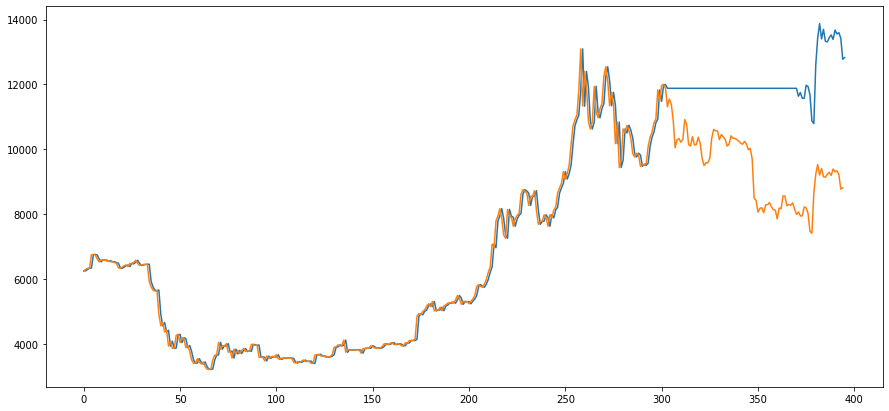

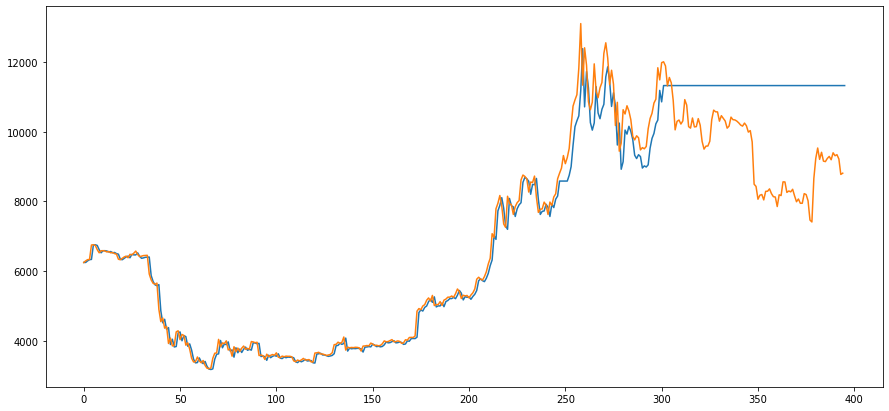

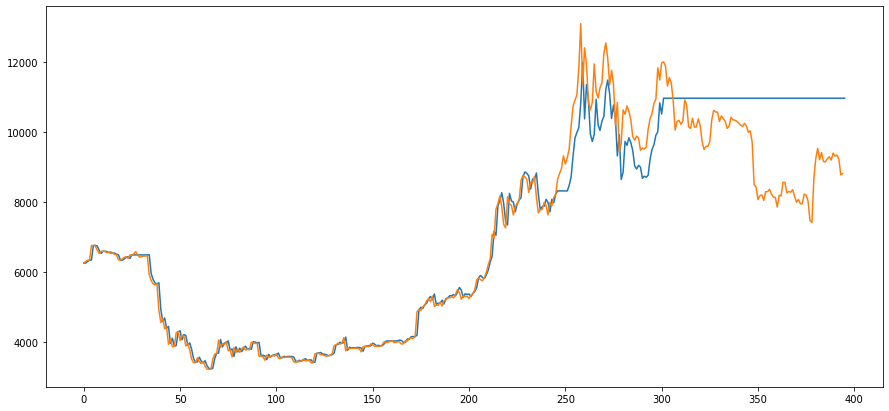

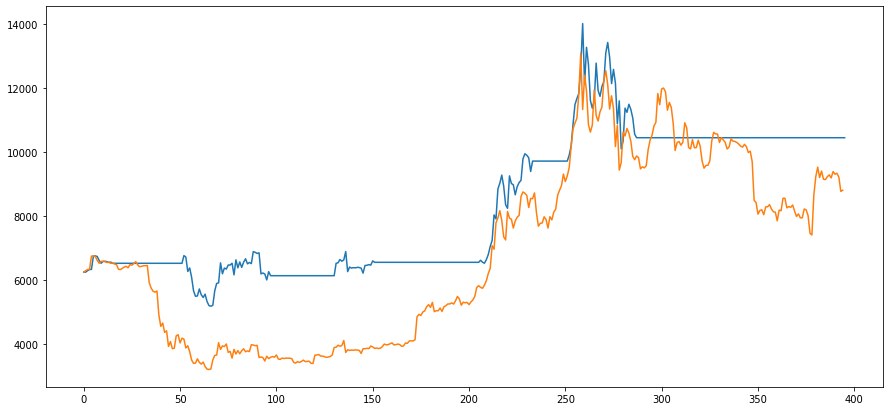

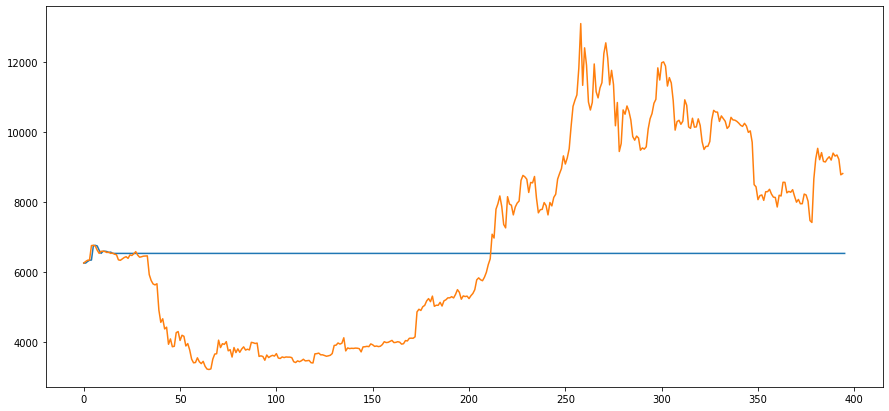

In [189]:
# Voting
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    plt.plot(np.array(k.loc[test_period, 'close']))

---

In [44]:
# Ada
for threshold in thresholds:
    fig, ax = plt.subplots(figsize=(15,7))
    plt.plot(np.array(funds_usdt_equivalent_dic[threshold])*scale)
    plt.plot(np.array(k.loc[test_period, 'close']))